## Getting the Data

https://www.kaggle.com/datasets/davidcariboo/player-scores

## Merging the Data

In [1]:
import pandas as pd
import numpy as np
import sklearn

In [2]:
#directory='C:/Users/Heidi Al Wakeel/Documents/GitHub/Football_Transfermarkt/Data/'
directory ="C:/Users/nguye/OneDrive/Documents/MMA/Winter 2023/Football_Transfermarkt/Data/"

In [3]:
# Reading CSV files into dataframes
appearances = pd.read_csv(directory+'appearances.csv')
club_games = pd.read_csv(directory+'club_games.csv')
clubs = pd.read_csv(directory+'clubs.csv')
competitions = pd.read_csv(directory+'competitions.csv')
game_events = pd.read_csv(directory+'game_events.csv')
games = pd.read_csv(directory+'games.csv')
player_valuations = pd.read_csv(directory+'player_valuations.csv')
players = pd.read_csv(directory+'players.csv')

In [4]:
# Yearly Player Game Stats
appearances['date'] = pd.to_datetime(appearances['date'])
appearances['year'] = appearances['date'].dt.year
player_games_stats = appearances.\
    groupby(['player_id', 'year']).\
    agg(avg_game_dur = ('minutes_played', 'mean'),
        avg_games_played = ('appearance_id', 'count'),
        avg_yellow_cards = ('yellow_cards', 'mean'),
        avg_red_cards = ('red_cards', 'mean'),
        avg_goals = ('goals', 'mean'),
        avg_assists = ('assists', 'mean'),
        avg_minutes_played = ('minutes_played', 'mean')).\
    reset_index()
player_games_stats.head(1)

,player_id,year,avg_game_dur,avg_games_played,avg_yellow_cards,avg_red_cards,avg_goals,avg_assists,avg_minutes_played
0,10,2014.0,33.066667,15,0.133333,0.0,0.266667,0.2,33.066667


In [5]:
# Yearly Player Games Played (away & home)
player_games_home_away = appearances[['player_id', 'game_id', 'player_club_id', 'year']].\
    rename(columns={'player_club_id':'club_id'}).\
    merge(club_games, on=['club_id', 'game_id'], how='left').\
    groupby(['player_id', 'year', 'hosting']).\
    agg(games_played = ('game_id', 'count')).\
    reset_index().\
    pivot(index=['player_id','year'], columns='hosting', values='games_played').\
    reset_index().\
    rename(columns={'Away': 'games_played_away', 'Home': 'games_played_home'})
player_games_home_away.head(1)

hosting,player_id,year,games_played_away,games_played_home
0,10,2014.0,7.0,8.0


In [6]:
# Yearly Player Win Percentage (away & home)
player_win_perc_home_away = appearances[['player_id', 'game_id', 'player_club_id', 'year']].\
    rename(columns={'player_club_id':'club_id'}).\
    merge(club_games, on=['club_id', 'game_id'], how='left').\
    groupby(['player_id', 'year', 'hosting']).\
    agg(win_perc = ('is_win', 'mean')).\
    reset_index().\
    pivot(index=['player_id','year'], columns='hosting', values='win_perc').\
    reset_index().\
    rename(columns={'Away': 'away_win_percentage', 'Home': 'home_win_percentage'})
player_win_perc_home_away.head(1)

hosting,player_id,year,away_win_percentage,home_win_percentage
0,10,2014.0,0.285714,0.75


In [7]:
# Yearly Player Win Percentage (total)
player_win_perc = appearances[['player_id', 'game_id', 'player_club_id', 'year']].\
    rename(columns={'player_club_id':'club_id'}).\
    merge(club_games, on=['club_id', 'game_id'], how='left').\
    groupby(['player_id', 'year']).\
    agg(win_perc = ('is_win', 'mean')).\
    reset_index()
player_win_perc.head(1)

,player_id,year,win_perc
0,10,2014.0,0.533333


In [8]:
# Yearly Games Played by Competition Type
player_comp_types = appearances[['player_id', 'game_id', 'year']].\
    merge(games, on='game_id', how='left').\
    groupby(['player_id', 'year', 'competition_type']).\
    agg(competitions_attended = ('game_id', 'count')).\
    reset_index().\
    pivot(index=['player_id','year'], columns='competition_type', values='competitions_attended').\
    reset_index().\
    fillna({'domestic_cup':0, 'domestic_league':0, 'international_cup':0, 'other':0}).\
    rename(columns={'domestic_cup': 'games_player_domestic_cup', 'domestic_league': 'games_played_domestic_league',
            'international_cup': 'games_player_international_cup', 'other': 'games_played_other'})
player_comp_types.head(1)

competition_type,player_id,year,games_player_domestic_cup,games_played_domestic_league,games_player_international_cup,games_played_other
0,10,2014.0,1.0,14.0,0.0,0.0


In [9]:
# Player Popularity
player_pop = appearances[['player_id', 'game_id', 'year']].\
    merge(games, on='game_id', how='left').\
    groupby(['player_id', 'year']).\
    agg(player_avg_game_attendance = ('attendance', 'mean')).\
    reset_index()
player_pop.head(1)

,player_id,year,player_avg_game_attendance
0,10,2014.0,25929.266667


In [10]:
# Player Stats
players['date_of_birth'] = pd.to_datetime(players['date_of_birth'])
players['year_of_birth'] = players['date_of_birth'].dt.year
player_relevant_stats = players[['player_id', 'country_of_citizenship', 'country_of_birth', 'city_of_birth', 'position', 'sub_position', 'foot', 'height_in_cm', 'year_of_birth']]
player_relevant_stats.head(1)

,player_id,country_of_citizenship,country_of_birth,city_of_birth,position,sub_position,foot,height_in_cm,year_of_birth
0,134354,Belgium,Belgium,Aalst,Attack,Centre-Forward,Right,0,1995.0


In [11]:
# Player Valuation (Mnay NA Values because it is tracked much earlier than stats)
player_valuations['date'] = pd.to_datetime(player_valuations['date'])
player_valuations['year'] = player_valuations['date'].dt.year
player_yearly_val =player_valuations.\
    groupby(['player_id', 'year']).\
    agg(mean_market_value_in_eur = ('market_value_in_eur', 'mean'),
        max_market_value_in_eur = ('market_value_in_eur', 'max')).\
    reset_index()

In [12]:
# Final Aggregation
data = player_games_stats.\
    merge(player_games_home_away, on=['player_id', 'year'], how='outer').\
    merge(player_win_perc_home_away, on=['player_id', 'year'], how='outer').\
    merge(player_win_perc, on=['player_id', 'year'], how='outer').\
    merge(player_comp_types, on=['player_id', 'year'], how='outer').\
    merge(player_pop, on=['player_id', 'year'], how='outer').\
    merge(player_yearly_val, on=['player_id', 'year'], how='outer').\
    merge(player_relevant_stats, on=['player_id'], how='left')
data['age'] = data['year'] - data['year_of_birth']
data.columns

Index(['player_id', 'year', 'avg_game_dur', 'avg_games_played',
       'avg_yellow_cards', 'avg_red_cards', 'avg_goals', 'avg_assists',
       'avg_minutes_played', 'games_played_away', 'games_played_home',
       'away_win_percentage', 'home_win_percentage', 'win_perc',
       'games_player_domestic_cup', 'games_played_domestic_league',
       'games_player_international_cup', 'games_played_other',
       'player_avg_game_attendance', 'mean_market_value_in_eur',
       'max_market_value_in_eur', 'country_of_citizenship', 'country_of_birth',
       'city_of_birth', 'position', 'sub_position', 'foot', 'height_in_cm',
       'year_of_birth', 'age'],
      dtype='object')

In [13]:
data.head()

,player_id,year,avg_game_dur,avg_games_played,avg_yellow_cards,avg_red_cards,avg_goals,avg_assists,avg_minutes_played,games_played_away,...,max_market_value_in_eur,country_of_citizenship,country_of_birth,city_of_birth,position,sub_position,foot,height_in_cm,year_of_birth,age
0,10,2014.0,33.066667,15.0,0.133333,0.0,0.266667,0.200000,33.066667,7.0,...,1000000.0,Germany,Poland,Opole,Attack,Centre-Forward,Right,184.0,1978.0,36.0
1,10,2015.0,67.472222,36.0,0.166667,0.0,0.333333,0.222222,67.472222,17.0,...,1000000.0,Germany,Poland,Opole,Attack,Centre-Forward,Right,184.0,1978.0,37.0
2,10,2016.0,53.900000,20.0,0.050000,0.0,0.400000,0.250000,53.900000,7.0,...,1000000.0,Germany,Poland,Opole,Attack,Centre-Forward,Right,184.0,1978.0,38.0
3,26,2014.0,90.000000,17.0,0.000000,0.0,0.000000,0.000000,90.000000,10.0,...,5000000.0,Germany,Germany,Diez,Goalkeeper,NaN,Left,190.0,1980.0,34.0
4,26,2015.0,90.000000,24.0,0.000000,0.0,0.000000,0.000000,90.000000,11.0,...,3000000.0,Germany,Germany,Diez,Goalkeeper,NaN,Left,190.0,1980.0,35.0


## Feature Engineering

In [14]:
from countryinfo import countries

In [15]:
country=[]
continent=[]
for i in countries :
    country.append(i['name'])
    continent.append(i['continent'])

In [16]:
mapping=pd.DataFrame({'country_of_citizenship':country,'continent':continent})

In [17]:
data=data.merge(mapping, on='country_of_citizenship', how='left')

In [18]:
data.drop(columns=['country_of_citizenship','country_of_birth','city_of_birth'],inplace=True)

In [19]:
data.head()

,player_id,year,avg_game_dur,avg_games_played,avg_yellow_cards,avg_red_cards,avg_goals,avg_assists,avg_minutes_played,games_played_away,...,player_avg_game_attendance,mean_market_value_in_eur,max_market_value_in_eur,position,sub_position,foot,height_in_cm,year_of_birth,age,continent
0,10,2014.0,33.066667,15.0,0.133333,0.0,0.266667,0.200000,33.066667,7.0,...,25929.266667,1000000.0,1000000.0,Attack,Centre-Forward,Right,184.0,1978.0,36.0,Europe
1,10,2015.0,67.472222,36.0,0.166667,0.0,0.333333,0.222222,67.472222,17.0,...,28502.472222,1000000.0,1000000.0,Attack,Centre-Forward,Right,184.0,1978.0,37.0,Europe
2,10,2016.0,53.900000,20.0,0.050000,0.0,0.400000,0.250000,53.900000,7.0,...,19311.600000,1000000.0,1000000.0,Attack,Centre-Forward,Right,184.0,1978.0,38.0,Europe
3,26,2014.0,90.000000,17.0,0.000000,0.0,0.000000,0.000000,90.000000,10.0,...,57578.411765,5000000.0,5000000.0,Goalkeeper,NaN,Left,190.0,1980.0,34.0,Europe
4,26,2015.0,90.000000,24.0,0.000000,0.0,0.000000,0.000000,90.000000,11.0,...,55057.333333,2000000.0,3000000.0,Goalkeeper,NaN,Left,190.0,1980.0,35.0,Europe


In [20]:
# For Imputation (Filling some null values with 0)
data = data.query('avg_games_played > 0')
#data = data.dropna(subset=['win_perc', 'mean_market_value_in_eur'])
data = data.fillna({'games_played_away': 0, 
                    'games_played_home': 0, 
                    'games_player_domestic_cup': 0, 
                    'games_played_domestic_league': 0, 
                    'games_player_international_cup': 0, 
                    'games_played_other': 0,
                    'away_win_percentage' : 0,
                    'home_win_percentage' : 0})

for col in data.columns:
    null_rows_idx = data[[col]].isnull().any(axis=1)
    if len(data[null_rows_idx]) > 0:
        print(col, data[null_rows_idx].shape)
# Output shows us which columns still have null values which we will fix/impute later in Data Cleaning

data.to_csv('data_merged.csv')

win_perc (122, 28)
mean_market_value_in_eur (2167, 28)
max_market_value_in_eur (2167, 28)
position (32, 28)
sub_position (5596, 28)
foot (1281, 28)
height_in_cm (32, 28)
year_of_birth (53, 28)
age (53, 28)
continent (11174, 28)


In [21]:
data.year_of_birth=data.year_of_birth.astype('str')

In [22]:
data['contribution_per_game']=data['avg_goals']+data['avg_assists']

## Analyzing the Data Structure

In [23]:
data.head()

,player_id,year,avg_game_dur,avg_games_played,avg_yellow_cards,avg_red_cards,avg_goals,avg_assists,avg_minutes_played,games_played_away,...,mean_market_value_in_eur,max_market_value_in_eur,position,sub_position,foot,height_in_cm,year_of_birth,age,continent,contribution_per_game
0,10,2014.0,33.066667,15.0,0.133333,0.0,0.266667,0.200000,33.066667,7.0,...,1000000.0,1000000.0,Attack,Centre-Forward,Right,184.0,1978.0,36.0,Europe,0.466667
1,10,2015.0,67.472222,36.0,0.166667,0.0,0.333333,0.222222,67.472222,17.0,...,1000000.0,1000000.0,Attack,Centre-Forward,Right,184.0,1978.0,37.0,Europe,0.555556
2,10,2016.0,53.900000,20.0,0.050000,0.0,0.400000,0.250000,53.900000,7.0,...,1000000.0,1000000.0,Attack,Centre-Forward,Right,184.0,1978.0,38.0,Europe,0.650000
3,26,2014.0,90.000000,17.0,0.000000,0.0,0.000000,0.000000,90.000000,10.0,...,5000000.0,5000000.0,Goalkeeper,NaN,Left,190.0,1980.0,34.0,Europe,0.000000
4,26,2015.0,90.000000,24.0,0.000000,0.0,0.000000,0.000000,90.000000,11.0,...,2000000.0,3000000.0,Goalkeeper,NaN,Left,190.0,1980.0,35.0,Europe,0.000000


In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64924 entries, 0 to 64923
Data columns (total 29 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   player_id                       64924 non-null  int64  
 1   year                            64924 non-null  float64
 2   avg_game_dur                    64924 non-null  float64
 3   avg_games_played                64924 non-null  float64
 4   avg_yellow_cards                64924 non-null  float64
 5   avg_red_cards                   64924 non-null  float64
 6   avg_goals                       64924 non-null  float64
 7   avg_assists                     64924 non-null  float64
 8   avg_minutes_played              64924 non-null  float64
 9   games_played_away               64924 non-null  float64
 10  games_played_home               64924 non-null  float64
 11  away_win_percentage             64924 non-null  float64
 12  home_win_percentage             

In [25]:
data.describe()

,player_id,year,avg_game_dur,avg_games_played,avg_yellow_cards,avg_red_cards,avg_goals,avg_assists,avg_minutes_played,games_played_away,...,games_player_domestic_cup,games_played_domestic_league,games_player_international_cup,games_played_other,player_avg_game_attendance,mean_market_value_in_eur,max_market_value_in_eur,height_in_cm,age,contribution_per_game
count,64924.000000,64924.000000,64924.000000,64924.000000,64924.000000,64924.000000,64924.000000,64924.000000,64924.000000,64924.000000,...,64924.000000,64924.000000,64924.000000,64924.000000,64924.000000,6.275700e+04,6.275700e+04,64892.000000,64871.000000,64924.000000
mean,201168.041957,2017.933692,63.651873,15.982965,0.140592,0.003807,0.074128,0.056940,63.651873,8.023335,...,1.046916,13.723415,1.166656,0.045977,14400.010437,3.874549e+06,4.394323e+06,180.097793,25.905227,0.131068
std,161988.736461,2.465908,24.158194,11.637990,0.155056,0.025462,0.131111,0.095831,24.158194,5.932188,...,1.378357,10.001174,2.546848,0.254883,12958.278553,8.994894e+06,9.949812e+06,20.483944,4.535568,0.182305
min,10.000000,2014.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+04,1.000000e+04,0.000000,15.000000,0.000000
25%,64992.000000,2016.000000,48.102586,6.000000,0.000000,0.000000,0.000000,0.000000,48.102586,3.000000,...,0.000000,5.000000,0.000000,0.000000,4345.424242,4.000000e+05,4.500000e+05,177.000000,22.000000,0.000000
50%,164912.500000,2018.000000,69.882353,14.000000,0.111111,0.000000,0.000000,0.000000,69.882353,7.000000,...,1.000000,13.000000,0.000000,0.000000,10650.525000,1.000000e+06,1.000000e+06,182.000000,26.000000,0.066667
75%,292357.000000,2020.000000,84.111111,24.000000,0.214286,0.000000,0.103448,0.090909,84.111111,12.000000,...,2.000000,20.000000,0.000000,0.000000,20633.825000,3.166667e+06,3.600000e+06,187.000000,29.000000,0.200000
max,987700.000000,2022.000000,120.000000,59.000000,2.000000,1.000000,3.000000,2.000000,120.000000,31.000000,...,11.000000,44.000000,19.000000,5.000000,83439.000000,2.000000e+08,2.000000e+08,206.000000,44.000000,3.000000


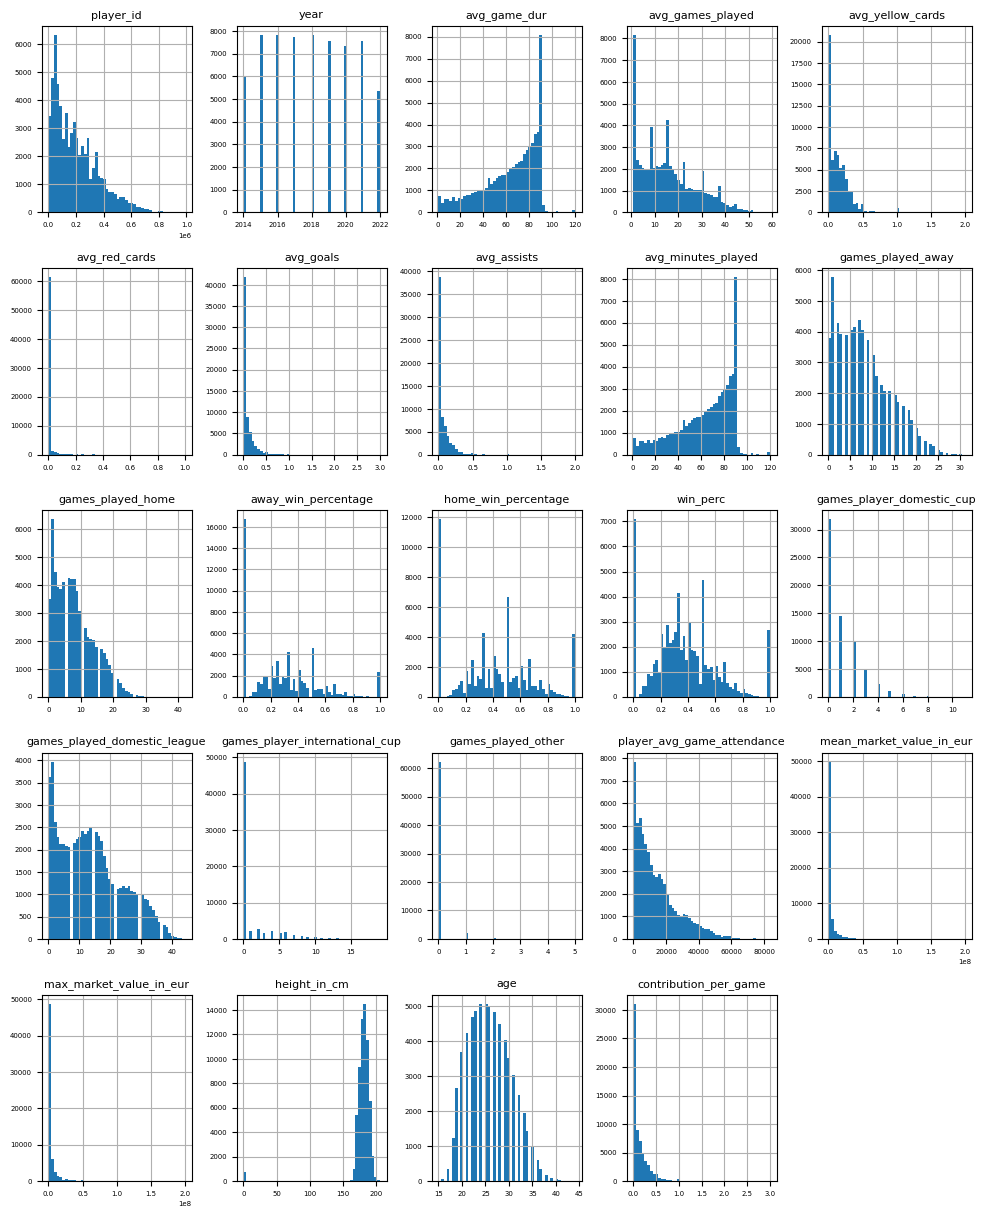

In [26]:
import matplotlib.pyplot as plt

plt.rc('font', size = 5)
plt.rc('axes', labelsize = 5, titlesize = 8)
plt.rc('legend', fontsize = 5)
plt.rc('xtick', labelsize = 5)
plt.rc('ytick', labelsize = 5)

data.hist(bins = 50, figsize = (12, 15))
plt.show()

Many variables are skewed to the left/right, meaning that they extend on the left/right of the median. This can make it difficult for our model to identify patterns. Later, we will transform these attributes to have normal distributions.

# Preparing the Data for Machine Learning Algorithms

## Data Cleaning

In [27]:
null_rows_idx = data.isnull().any(axis=1)
data.loc[null_rows_idx].head()

,player_id,year,avg_game_dur,avg_games_played,avg_yellow_cards,avg_red_cards,avg_goals,avg_assists,avg_minutes_played,games_played_away,...,mean_market_value_in_eur,max_market_value_in_eur,position,sub_position,foot,height_in_cm,year_of_birth,age,continent,contribution_per_game
3,26,2014.0,90.000000,17.0,0.000000,0.0,0.0,0.0,90.000000,10.0,...,5.000000e+06,5000000.0,Goalkeeper,NaN,Left,190.0,1980.0,34.0,Europe,0.0
4,26,2015.0,90.000000,24.0,0.000000,0.0,0.0,0.0,90.000000,11.0,...,2.000000e+06,3000000.0,Goalkeeper,NaN,Left,190.0,1980.0,35.0,Europe,0.0
5,26,2016.0,92.000000,15.0,0.066667,0.0,0.0,0.0,92.000000,9.0,...,1.000000e+06,1000000.0,Goalkeeper,NaN,Left,190.0,1980.0,36.0,Europe,0.0
6,26,2017.0,60.333333,3.0,0.000000,0.0,0.0,0.0,60.333333,1.0,...,9.166667e+05,1000000.0,Goalkeeper,NaN,Left,190.0,1980.0,37.0,Europe,0.0
7,26,2018.0,1.000000,1.0,0.000000,0.0,0.0,0.0,1.000000,1.0,...,NaN,NaN,Goalkeeper,NaN,Left,190.0,1980.0,38.0,Europe,0.0


In [28]:
null_counts = data.isnull().sum(axis=1)
num_null_rows = (null_counts > 0).sum()

print(f'There are {num_null_rows} rows with null values in the dataset.')

There are 17932 rows with null values in the dataset.


## Advanced Imputation

In [29]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

num_cols = ['win_perc','age','height_in_cm','mean_market_value_in_eur','max_market_value_in_eur']
imputer = IterativeImputer()
imputed = imputer.fit_transform(data[num_cols])
data.loc[:, num_cols] = imputed

In [30]:
from sklearn.impute import SimpleImputer

# create an imputer that uses the most frequent strategy
imputer = SimpleImputer(strategy='most_frequent')

cat_cols=['continent','year_of_birth','foot','position']

# fit the imputer on the data frame
imputer.fit(data[cat_cols])

# transform the data frame
data[cat_cols] = imputer.transform(data[cat_cols])

In [31]:
# Filling in missing sub_position values

# Grouping sub_position by position
sub_positions_by_position = data.groupby('position')['sub_position'].apply(list)

# Finding the most frequent sub_position for each position
sub_positions_count_by_position = sub_positions_by_position.apply(lambda x: pd.Series(x).value_counts()).fillna(0).astype(int)
sub_positions_count_by_position_dict = sub_positions_count_by_position.to_dict()

# Finding the most frequent sub_position for each position
most_frequent_sub_positions_by_position = sub_positions_count_by_position.idxmax(axis=1)

# Creating a new DataFrame with position and most frequent sub_position columns
df = pd.DataFrame({'position': most_frequent_sub_positions_by_position.index,
                   'most_frequent_sub_position': most_frequent_sub_positions_by_position.values})

df

,position,most_frequent_sub_position
0,Attack,Centre-Forward
1,Defender,Centre-Back
2,Goalkeeper,Centre-Forward
3,Midfield,Central Midfield


In [32]:
df_merged = df.merge(sub_positions_count_by_position, left_on='position', right_index=True)
most_frequent_sub_positions_dict = df_merged.set_index('position')['most_frequent_sub_position'].to_dict()

# Replace sub_position null values with most frequent sub_positions for their corresponding positions
data['sub_position'] = data.apply(lambda row: most_frequent_sub_positions_dict[row['position']] if pd.isnull(row['sub_position']) else row['sub_position'], axis=1)

In [33]:
# Just to be sure that all worked, count the number of null values in the sub_position column
num_null_values = data['sub_position'].isnull().sum()

print(f"There are {num_null_values} null values in the sub_position column")

There are 0 null values in the sub_position column


In [34]:
# Just to make sure eveyrthing worked
null_counts = data.isnull().sum(axis=1)
num_null_rows = (null_counts > 0).sum()

print(f'There are {num_null_rows} rows with null values in the dataset.')

There are 0 rows with null values in the dataset.


## Handling Text and Categorical Attributes

In [35]:
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder

## Entity Embedding

In [36]:
cat_cols=['continent','position','sub_position']

for i in cat_cols:  
    
    le = LabelEncoder()
    data[i] = le.fit_transform(data[i])

    # Define the number of categories and the embedding size
    num_categories = data[i].nunique()
    embedding_dim = data[i].nunique()//2

    # Create a tensor of categorical values
    categorical_column = torch.randint(low=0, high=num_categories, size=(len(data[i]),))

    # Create the embedding layer
    embedding_layer = nn.Embedding(num_embeddings=num_categories, embedding_dim=embedding_dim)

    # Apply the embedding layer to the categorical column
    embedded_column = embedding_layer(categorical_column)

    embedded_df = pd.DataFrame(embedded_column.detach().numpy(), columns=[i+f'_embed_{j}' for j in range(embedding_dim)])

    # Replace the original categorical column with the embedded DataFrame
    data = pd.concat([data.drop(i, axis=1), embedded_df], axis=1)

## One Hot Encoding

In [37]:
data.drop(columns='year_of_birth',inplace=True)
dummy_vars = pd.get_dummies(data['foot'],drop_first=True,prefix='foot')

data = pd.concat([data, dummy_vars], axis=1)
data.drop(columns='foot',inplace=True)

# Eliminate the ID columns

In [38]:
#data = data.drop(columns = "player_id")

### Split data

In [39]:
import numpy as np

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

train_set,valid_set=split_train_test(data,0.3)
print("The length of train set is: ",len(train_set))
print("The length of valid set is: ",len(valid_set))



The length of train set is:  45447
The length of valid set is:  19477


In [40]:
valid_set,test_set=split_train_test(valid_set,0.4)
print("The length of valid set is: ",len(valid_set))
print("The length of test set is: ",len(test_set))
train_set.shape, test_set.shape

The length of valid set is:  11687
The length of test set is:  7790


((45447, 37), (7790, 37))

In [41]:
#Separate Features and Target
y_test = test_set['mean_market_value_in_eur']
X_test = test_set.drop(columns=['mean_market_value_in_eur','max_market_value_in_eur'])


### Separate Predictors and Target Variable


In [42]:
y_train = train_set['mean_market_value_in_eur']
X_train = train_set.drop(columns=['mean_market_value_in_eur','max_market_value_in_eur']) ##taking anything related to market value to avoid data leakage
y_valid = valid_set['mean_market_value_in_eur']
X_valid= valid_set.drop(columns=['mean_market_value_in_eur','max_market_value_in_eur']) ##t

Extract the player ID column

In [43]:
X_train_id = X_train["player_id"]
X_valid_id = X_valid["player_id"]
X_test_id = X_test['player_id']
X_train = X_train.drop(columns = "player_id")
X_test = X_test.drop(columns = "player_id")

In [44]:
X_valid = X_valid.drop(columns = "player_id")

### Standardize Data

In [45]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_valid_std = sc.transform(X_valid)
X_test_std = sc.transform(X_test)
#X_std = sc.fit_transform(X)
#X_std = pd.DataFrame(X_std,columns = X.columns)
X_valid_std = pd.DataFrame(X_valid_std,columns = X_valid.columns)
X_train_std = pd.DataFrame(X_train_std,columns = X_train.columns)
X_test_std = pd.DataFrame(X_test_std,columns = X_test.columns)


In [46]:
from sklearn.ensemble import RandomForestRegressor
randomforest = RandomForestRegressor(random_state=0)
model = randomforest.fit(X_train_std,y_train)
model.feature_importances_
pd.DataFrame(list(zip(X_train.columns,model.feature_importances_)), columns=['predictor', 'feature importance']).sort_values("feature importance")


,predictor,feature importance
33,foot_Right,0.001453
32,foot_Left,0.001501
4,avg_red_cards,0.002722
25,position_embed_1,0.003190
24,position_embed_0,0.003467
23,continent_embed_2,0.005030
22,continent_embed_1,0.005433
21,continent_embed_0,0.005661
31,sub_position_embed_5,0.006361
30,sub_position_embed_4,0.006769


In [47]:
model_features = pd.DataFrame(list(zip(X_train_std.columns,model.feature_importances_)), columns = ['predictor','feature importance']).sort_values("feature importance")
model_features.tail(20)

,predictor,feature importance
27,sub_position_embed_1,0.007892
13,games_player_domestic_cup,0.008100
1,avg_game_dur,0.012893
7,avg_minutes_played,0.013642
3,avg_yellow_cards,0.015059
10,away_win_percentage,0.015857
18,height_in_cm,0.017886
11,home_win_percentage,0.019145
14,games_played_domestic_league,0.019334
6,avg_assists,0.020412


###  Recursive Feature Elimination 

In [48]:
from sklearn.feature_selection import RFE
rfe = RFE(randomforest, n_features_to_select = 20)
rfe.fit(X_train_std, y_train)
print(rfe.ranking_)

[ 1  1  1  1 13  1  1  1  1  1  1  1  1  3  1  1  7  1  1  1  1  5  8 11
 10 12  6  1  4  1  2  9 14 15]


In [49]:
# Define the feature names
feature_names = X_train_std.columns.tolist()
# Print the names of the important features
important_features = [i for i, x in enumerate(rfe.support_) if x]
selected_features = [feature_names[i] for i in important_features]
print("Important features:", selected_features)

Important features: ['year', 'avg_game_dur', 'avg_games_played', 'avg_yellow_cards', 'avg_goals', 'avg_assists', 'avg_minutes_played', 'games_played_away', 'games_played_home', 'away_win_percentage', 'home_win_percentage', 'win_perc', 'games_played_domestic_league', 'games_player_international_cup', 'player_avg_game_attendance', 'height_in_cm', 'age', 'contribution_per_game', 'sub_position_embed_1', 'sub_position_embed_3']


In [50]:
X_train_std = X_train_std[selected_features]
X_valid_std = X_valid_std[selected_features]
X_test_std = X_test_std[selected_features]

### PCA

In [51]:
from sklearn.decomposition import PCA

# Perform PCA on the training set
pca = PCA(n_components=X_train_std.shape[1])
X_train_pca = pca.fit_transform(X_train_std)

# Choose the number of components that explain at least 80% of the variance
cumulative_variance_ratio = pca.explained_variance_ratio_.cumsum()
n_components = len(cumulative_variance_ratio[cumulative_variance_ratio <= 0.8])
# Fit the PCA object with the selected number of components
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)
X_valid_pca = pca.transform(X_valid_std)

In [52]:
n_components

8

In [53]:
#from sklearn.decomposition import PCA
#scaler = StandardScaler()
#scaler.fit(train_set)
#scaled_data = scaler.transform(train_set)
#pca = PCA(n_components=2)
#pca.fit(scaled_data)
#x_pca = pca.transform(scaled_data)
#plt.figure(figsize=(8,6))
#plt.scatter(x_pca[:,0],x_pca[:,1],c=train_set['mean_market_value_in_eur'],cmap='tab20b')
#plt.xlabel('First principal component')
#plt.ylabel('Second Principal Component')

In [54]:
#import seaborn as sns
#map= pd.DataFrame(pca.components_,columns=train_set.columns)
#plt.figure(figsize=(12,6))
#sns.heatmap(map,cmap='twilight')

### Supervised Learning/ AutoML

In [55]:
# !pip install h2o
# --upgrade pip



In [56]:
import h2o
# from h2o.automl import H2OAutoML
# # initialize the h2o session
# h2o.init()
# load an h2o DataFrame from pandas DataFrame.

In [57]:
from h2o.automl import H2OAutoML

In [58]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.7+8-LTS-224, mixed mode, sharing)
  Starting server from C:\Users\nguye\anaconda3\envs\MGSC662\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\nguye\AppData\Local\Temp\tmpej22qo9v
  JVM stdout: C:\Users\nguye\AppData\Local\Temp\tmpej22qo9v\h2o_nguye_started_from_python.out
  JVM stderr: C:\Users\nguye\AppData\Local\Temp\tmpej22qo9v\h2o_nguye_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.3
H2O_cluster_version_age:,22 days
H2O_cluster_name:,H2O_from_python_nguye_uwkrwo
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.807 Gb
H2O_cluster_total_cores:,0
H2O_cluster_allowed_cores:,0
H2O_cluster_status:,"locked, healthy"


In [59]:
train_set.to_csv('automl_train.csv')
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45447 entries, 21178 to 24028
Data columns (total 37 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   player_id                       45447 non-null  int64  
 1   year                            45447 non-null  float64
 2   avg_game_dur                    45447 non-null  float64
 3   avg_games_played                45447 non-null  float64
 4   avg_yellow_cards                45447 non-null  float64
 5   avg_red_cards                   45447 non-null  float64
 6   avg_goals                       45447 non-null  float64
 7   avg_assists                     45447 non-null  float64
 8   avg_minutes_played              45447 non-null  float64
 9   games_played_away               45447 non-null  float64
 10  games_played_home               45447 non-null  float64
 11  away_win_percentage             45447 non-null  float64
 12  home_win_percentage         

In [60]:
df_test = h2o.import_file('automl_train.csv')

x = list(train_set.describe().columns)
x.remove('mean_market_value_in_eur')
x.remove('max_market_value_in_eur')
aml = H2OAutoML(max_models=10, seed=1)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [61]:
df_test

C1,player_id,year,avg_game_dur,avg_games_played,avg_yellow_cards,avg_red_cards,avg_goals,avg_assists,avg_minutes_played,games_played_away,games_played_home,away_win_percentage,home_win_percentage,win_perc,games_player_domestic_cup,games_played_domestic_league,games_player_international_cup,games_played_other,player_avg_game_attendance,mean_market_value_in_eur,max_market_value_in_eur,height_in_cm,age,contribution_per_game,continent_embed_0,continent_embed_1,continent_embed_2,position_embed_0,position_embed_1,sub_position_embed_0,sub_position_embed_1,sub_position_embed_2,sub_position_embed_3,sub_position_embed_4,sub_position_embed_5,foot_Left,foot_Right
21178,89618,2015,90,21,0.142857,0,0,0,90,11,10,0.181818,0.5,0.333333,2,19,0,0,13319.1,1.66667e+06,2e+06,179,29,0,-0.184235,1.44508,0.327949,1.26956,0.0978737,-0.412386,-1.46621,0.567165,-0.959432,-0.370101,-1.15797,0,1
15408,61653,2020,57.5789,19,0.105263,0,0.0526316,0.210526,57.5789,10,9,0.2,0.333333,0.263158,1,18,0,0,8869.37,6e+06,6e+06,181,29,0.263158,-0.184235,1.44508,0.327949,1.9796,-0.10526,0.470473,0.467103,1.32873,0.150942,0.724101,-0.118934,1,0
39391,212415,2016,61.4545,11,0.272727,0,0.272727,0.0909091,61.4545,6,5,0,0.4,0.181818,0,11,0,0,5239.55,650000,650000,175,24,0.363636,0.0744412,1.16121,-0.356306,0.115808,0.367102,0.825388,1.71098,0.171539,0.446716,0.169024,0.325681,0,1
53816,351837,2017,49.875,8,0.375,0,0,0,49.875,4,4,0.25,0.25,0.25,0,8,0,0,10249.9,950000,1e+06,184,28,0,-0.184235,1.44508,0.327949,0.0343816,1.57136,-0.846146,0.331541,-0.829335,0.125831,-0.106015,-0.176994,0,0
54114,354909,2021,31.3333,3,0,0,0,0,31.3333,0,3,0,0.666667,0.666667,2,1,0,0,4517.33,166667,200000,190,23,0,-0.184235,1.44508,0.327949,1.26956,0.0978737,0.527241,0.766767,-1.22117,-0.160642,-1.40075,-0.626501,0,1
17733,72740,2015,52.5714,14,0.0714286,0.0714286,0,0.0714286,52.5714,7,7,0.142857,0.285714,0.214286,0,14,0,0,7482.71,125000,125000,189,25,0.0714286,0.0744412,1.16121,-0.356306,1.9796,-0.10526,0.470473,0.467103,1.32873,0.150942,0.724101,-0.118934,1,0
60249,476915,2022,32,8,0,0,0,0,32,3,5,0.666667,0.2,0.375,1,7,0,0,13086.8,1.2e+06,1.2e+06,184,20,0,-0.60809,-0.664128,0.00831068,1.26956,0.0978737,-2.55614,-0.937139,-0.144441,-0.329893,0.799124,-1.65303,0,1
63298,599263,2020,43,2,0,0,0,0,43,0,2,0,0.5,0.5,1,1,0,0,5576,533333,1e+06,180,21,0,-0.60809,-0.664128,0.00831068,0.115808,0.367102,-2.55614,-0.937139,-0.144441,-0.329893,0.799124,-1.65303,1,0
50734,320411,2020,69.875,16,0.125,0,0.1875,0,69.875,8,8,0.125,0.5,0.3125,1,15,0,0,11287.1,1.08333e+07,1.45e+07,193,24,0.1875,-0.461632,-0.672448,0.569036,0.0343816,1.57136,-0.89827,0.738596,0.832751,-0.591845,0.157906,0.541589,1,0
47639,285634,2018,18,1,0,0,0,0,18,0,1,0,1,1,0,1,0,0,0,675000,750000,183,24,0,-0.184235,1.44508,0.327949,0.115808,0.367102,-0.692848,0.622187,1.79975,-1.83183,0.650443,-1.24583,0,1


In [62]:
pred=aml.train(x=x, y='mean_market_value_in_eur', training_frame=df_test)
lb = aml.leaderboard # Leader board
print(lb.head(rows=lb.nrows)) # print leader board

AutoML progress: |
10:07:09.688: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%
model_id                                                        rmse          mse          mae      rmsle    mean_residual_deviance
StackedEnsemble_AllModels_1_AutoML_1_20230427_100709     5.04436e+06  2.54456e+13  2.20174e+06  nan                     2.54456e+13
StackedEnsemble_BestOfFamily_1_AutoML_1_20230427_100709  5.093e+06    2.59387e+13  2.22989e+06  nan                     2.59387e+13
GBM_3_AutoML_1_20230427_100709                           5.10649e+06  2.60762e+13  2.25099e+06  nan                     2.60762e+13
GBM_2_AutoML_1_20230427_100709                           5.1153e+06   2.61663e+13  2.25952e+06  nan                     2.61663e+13
GBM_4_AutoML_1_20230427_100709                           5.1347e+06   2.63651e+13  2.24419e+06  nan                     2.63651e+13
GBM_5_AutoML_1_20230427_100709                    

In [63]:
valid_set.to_csv('for_automl_test.csv')


In [64]:
test = h2o.import_file('for_automl_test.csv')
preds = aml.predict(test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


In [65]:
preds

predict
759628
684538
1.88178e+06
7.7272e+06
4.50077e+06
2.03149e+06
1.87336e+06
1.18227e+06
1.08269e+06
6.32451e+06


In [66]:
list_model=h2o.as_list(lb.head(rows=lb.nrows)['model_id'], use_pandas=False)
import itertools

list_m = list(itertools.chain(*list_model))
list_m


['model_id',
 'StackedEnsemble_AllModels_1_AutoML_1_20230427_100709',
 'StackedEnsemble_BestOfFamily_1_AutoML_1_20230427_100709',
 'GBM_3_AutoML_1_20230427_100709',
 'GBM_2_AutoML_1_20230427_100709',
 'GBM_4_AutoML_1_20230427_100709',
 'GBM_5_AutoML_1_20230427_100709',
 'GBM_1_AutoML_1_20230427_100709',
 'DRF_1_AutoML_1_20230427_100709',
 'GBM_grid_1_AutoML_1_20230427_100709_model_1',
 'XRT_1_AutoML_1_20230427_100709',
 'DeepLearning_1_AutoML_1_20230427_100709',
 'GLM_1_AutoML_1_20230427_100709']

### Explainability of AutoML

# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id,rmse,mse,mae,rmsle,mean_residual_deviance,training_time_ms,predict_time_per_row_ms,algo
StackedEnsemble_AllModels_1_AutoML_1_20230427_100709,4.87162e+06,2.37327e+13,2.17312e+06,nan,2.37327e+13,1388,0.021238,StackedEnsemble
GBM_3_AutoML_1_20230427_100709,4.94177e+06,2.44211e+13,2.22009e+06,nan,2.44211e+13,2216,0.002584,GBM
StackedEnsemble_BestOfFamily_1_AutoML_1_20230427_100709,4.94223e+06,2.44256e+13,2.20372e+06,nan,2.44256e+13,1713,0.0086,StackedEnsemble
GBM_4_AutoML_1_20230427_100709,4.94346e+06,2.44378e+13,2.2054e+06,nan,2.44378e+13,3379,0.002707,GBM
GBM_2_AutoML_1_20230427_100709,4.94907e+06,2.44933e+13,2.22503e+06,nan,2.44933e+13,1817,0.002796,GBM
GBM_5_AutoML_1_20230427_100709,5.03592e+06,2.53605e+13,2.25303e+06,nan,2.53605e+13,1789,0.002783,GBM
GBM_1_AutoML_1_20230427_100709,5.16549e+06,2.66823e+13,2.28948e+06,nan,2.66823e+13,4673,0.004721,GBM
GBM_grid_1_AutoML_1_20230427_100709_model_1,5.27272e+06,2.78016e+13,2.46364e+06,nan,2.78016e+13,4757,0.005241,GBM
DRF_1_AutoML_1_20230427_100709,5.3172e+06,2.82727e+13,2.36963e+06,1.10059,2.82727e+13,22155,0.004476,DRF
XRT_1_AutoML_1_20230427_100709,5.47719e+06,2.99996e+13,2.45782e+06,1.12734,2.99996e+13,24665,0.004475,DRF


# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

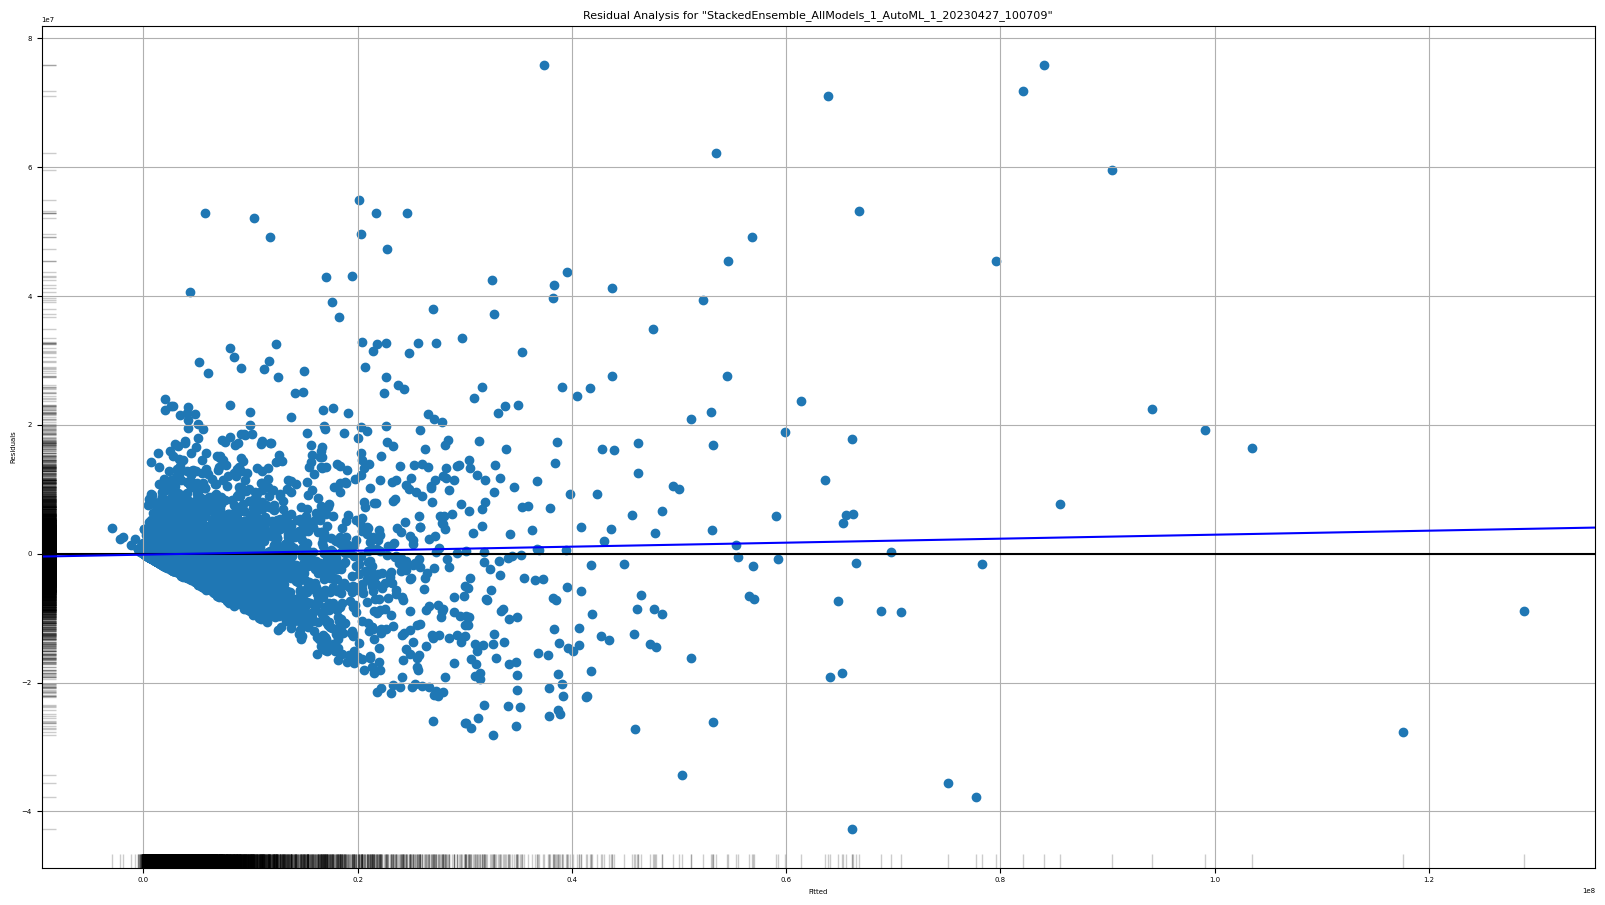

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

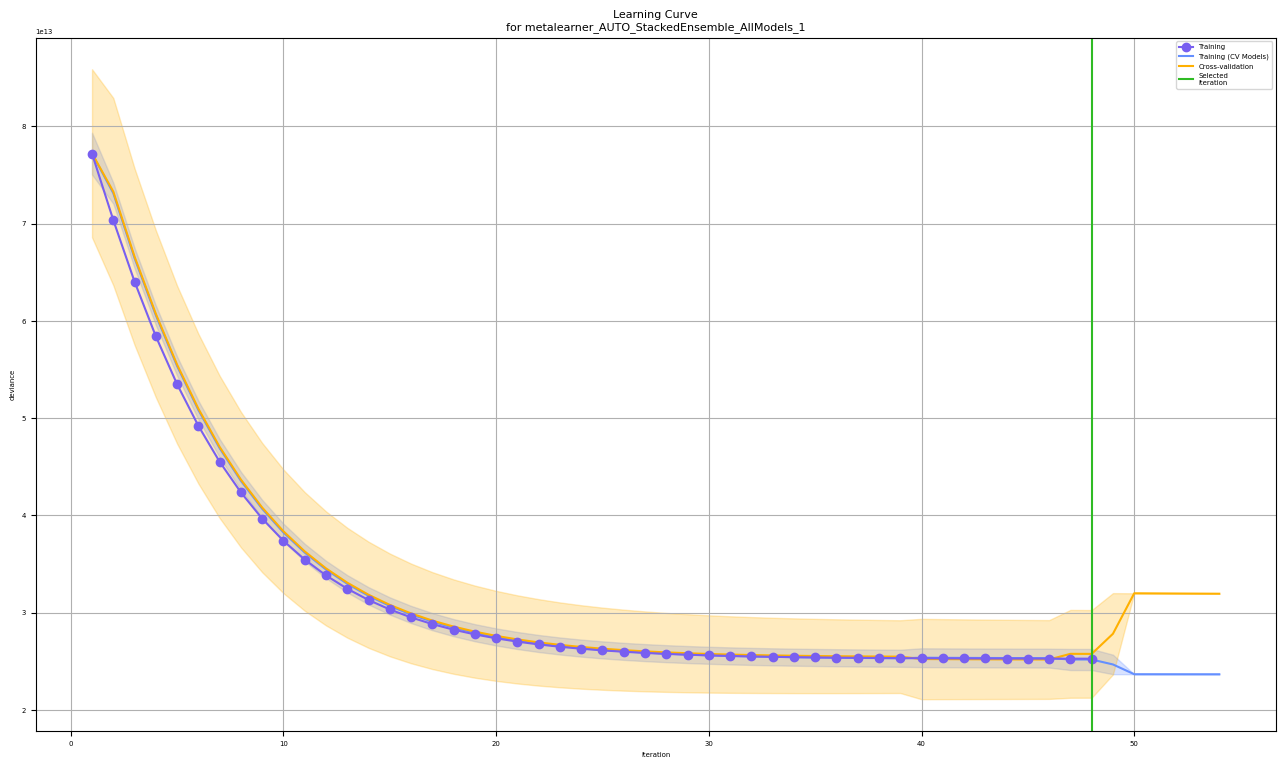

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

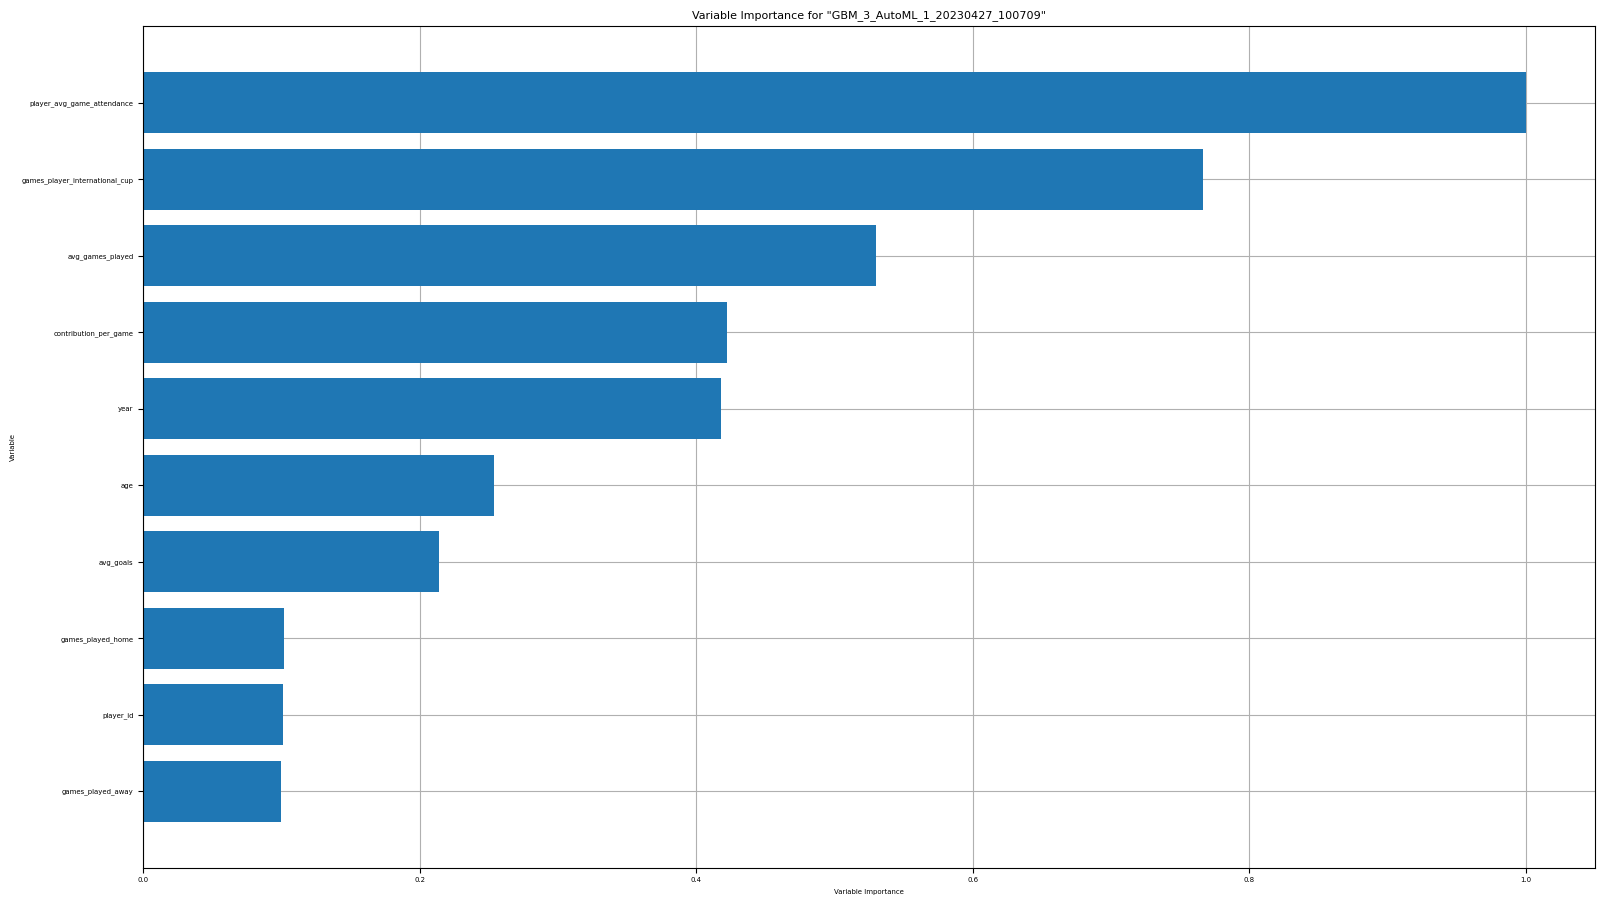

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

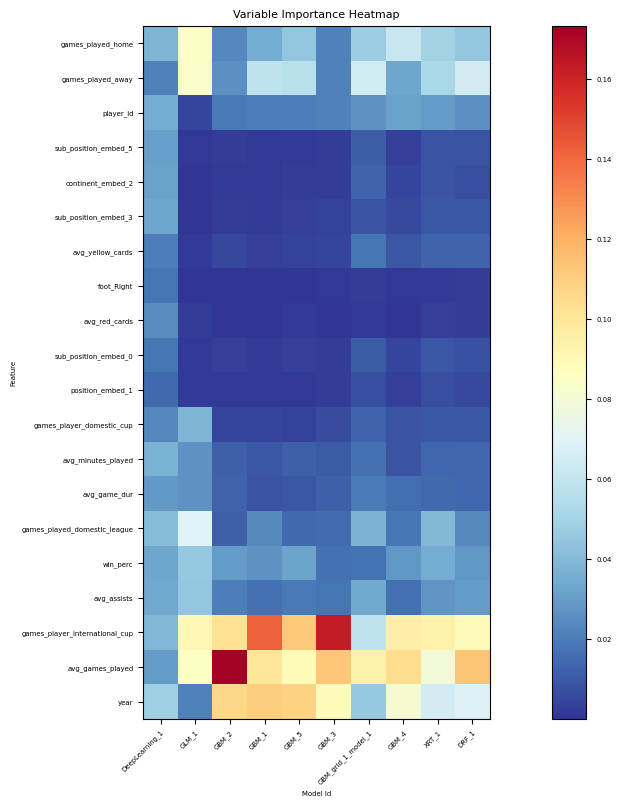

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

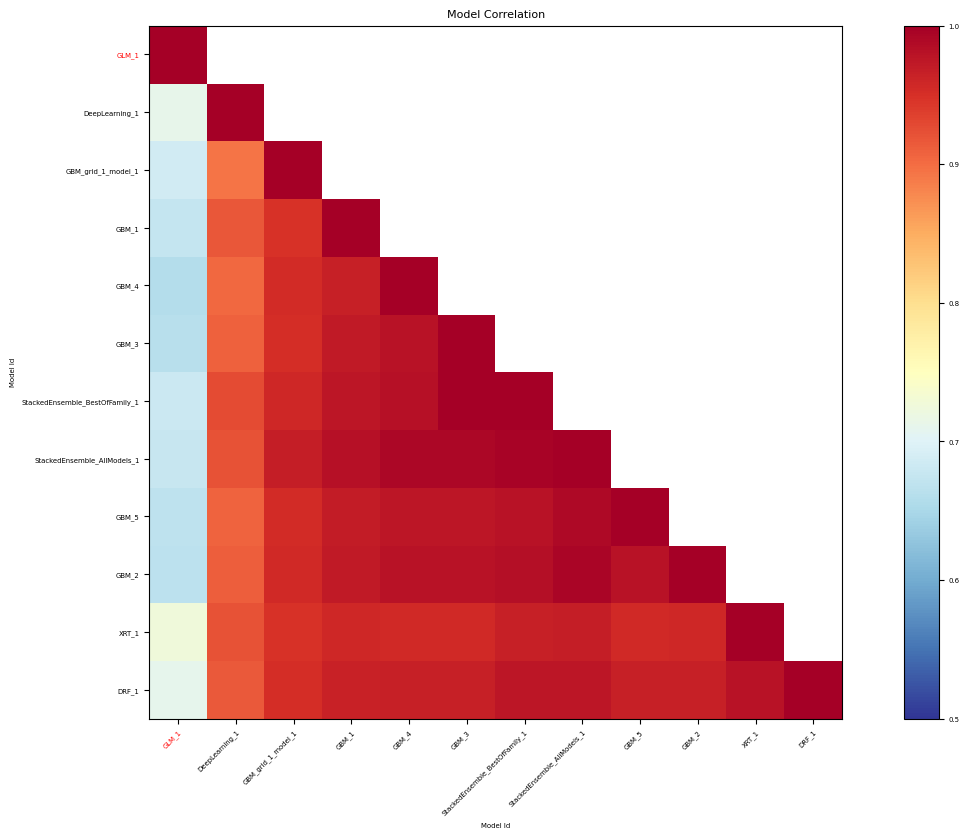

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

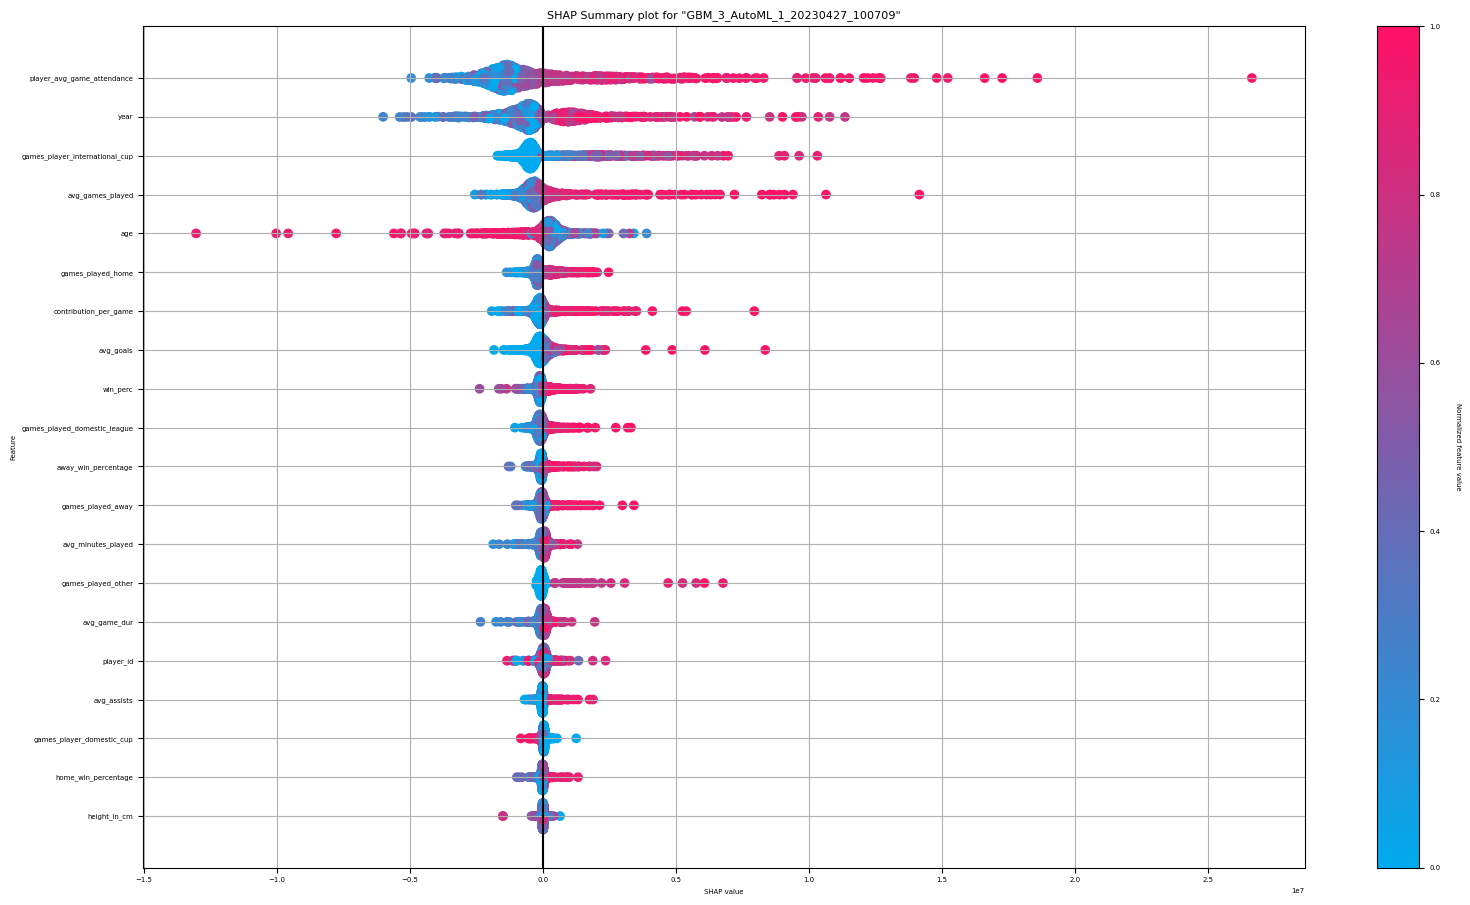

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

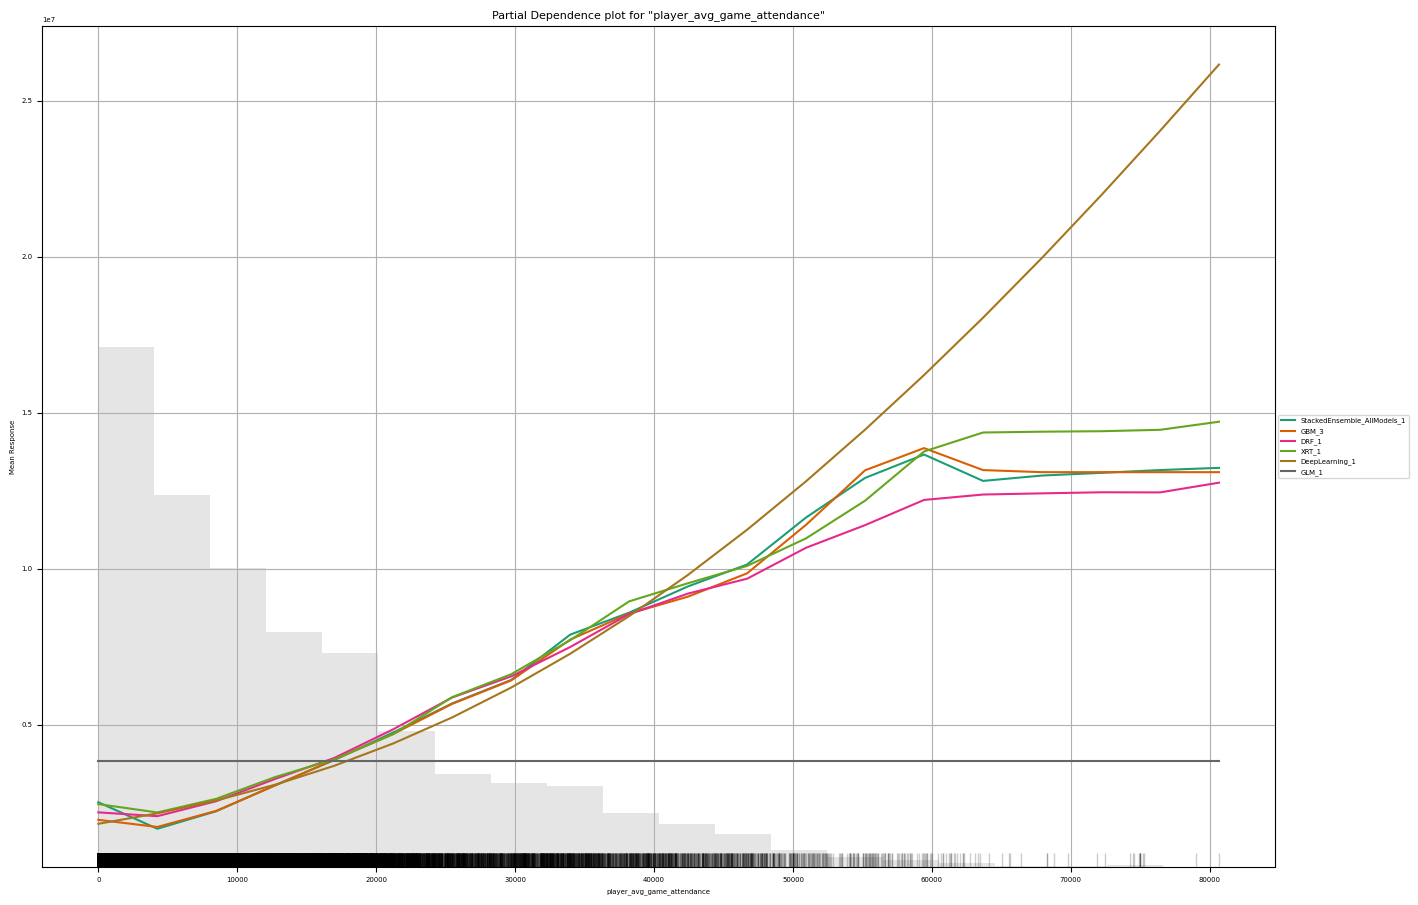

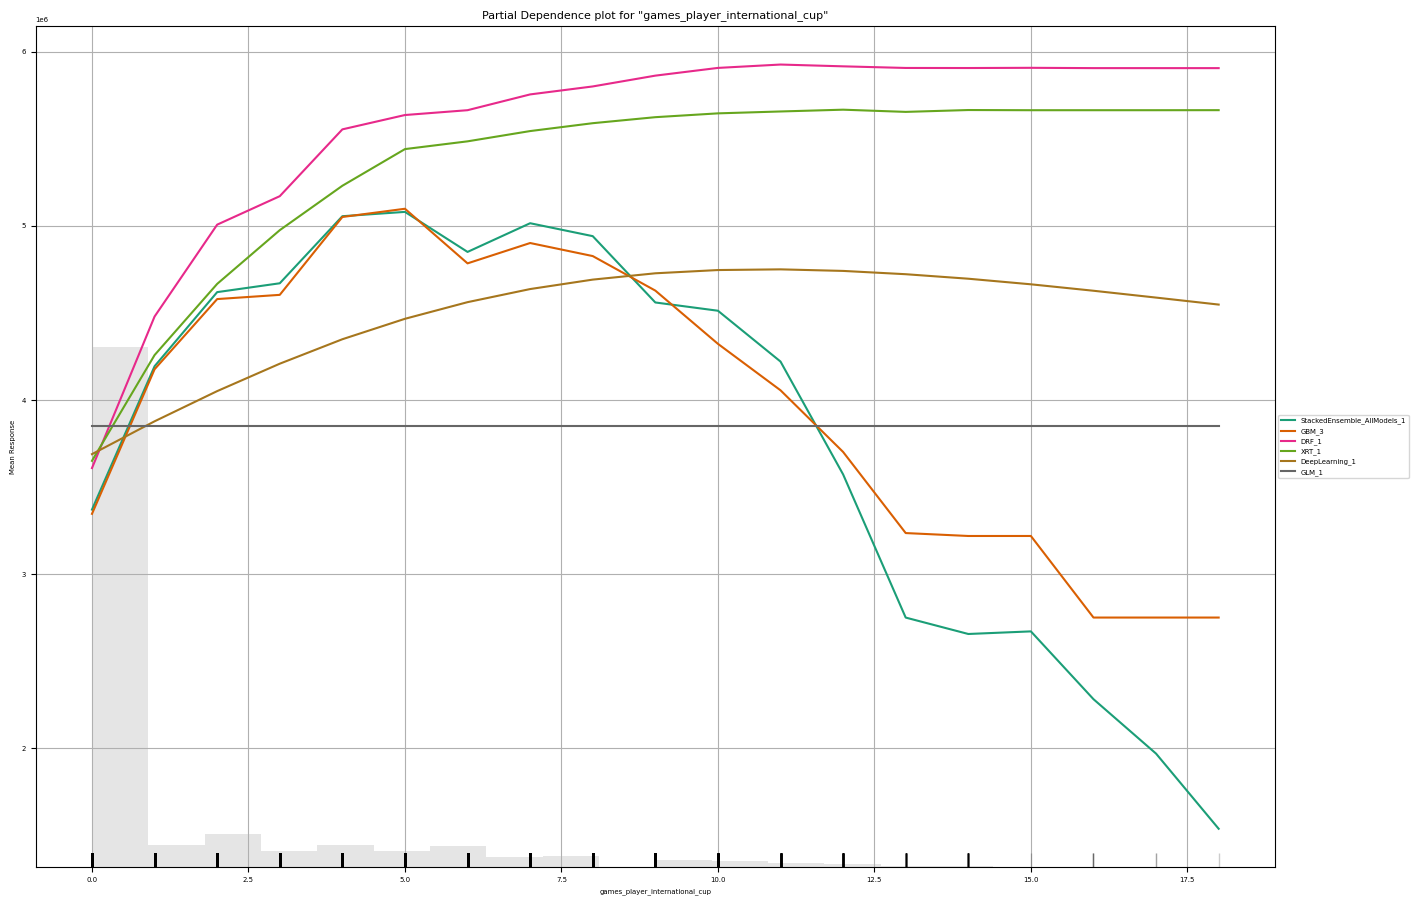

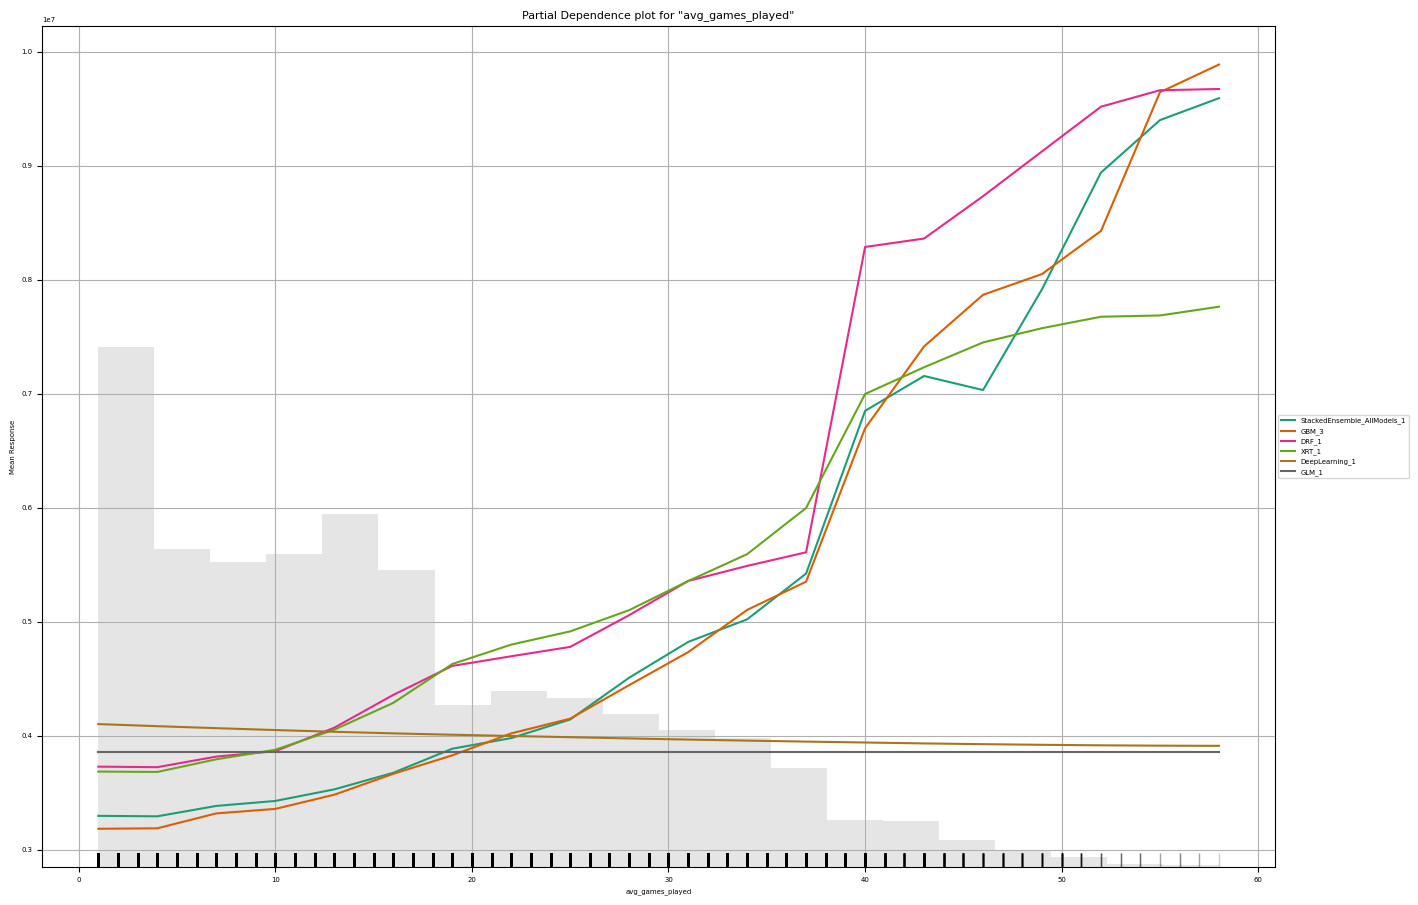

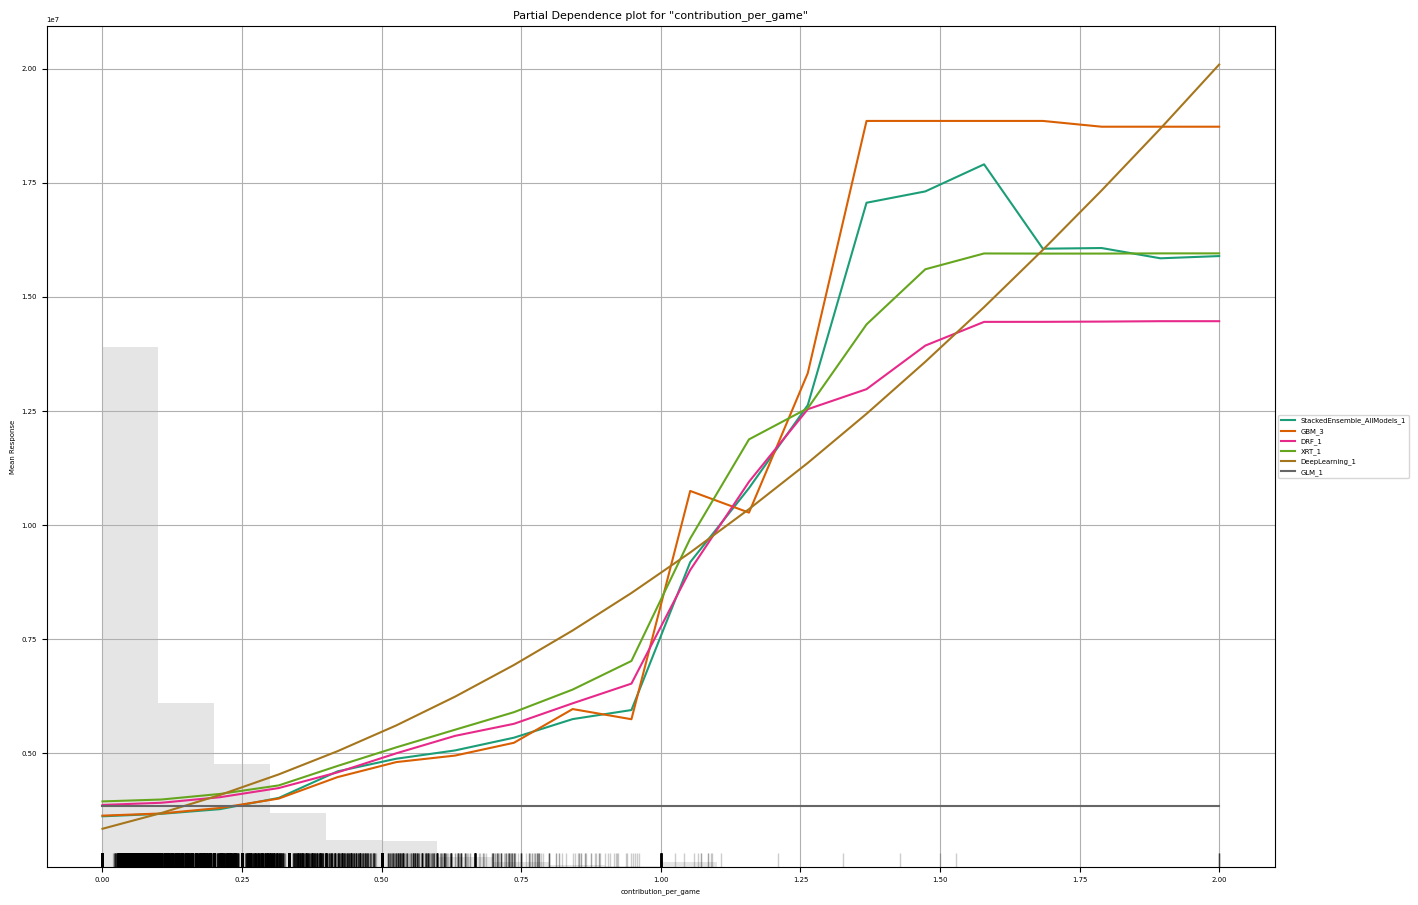

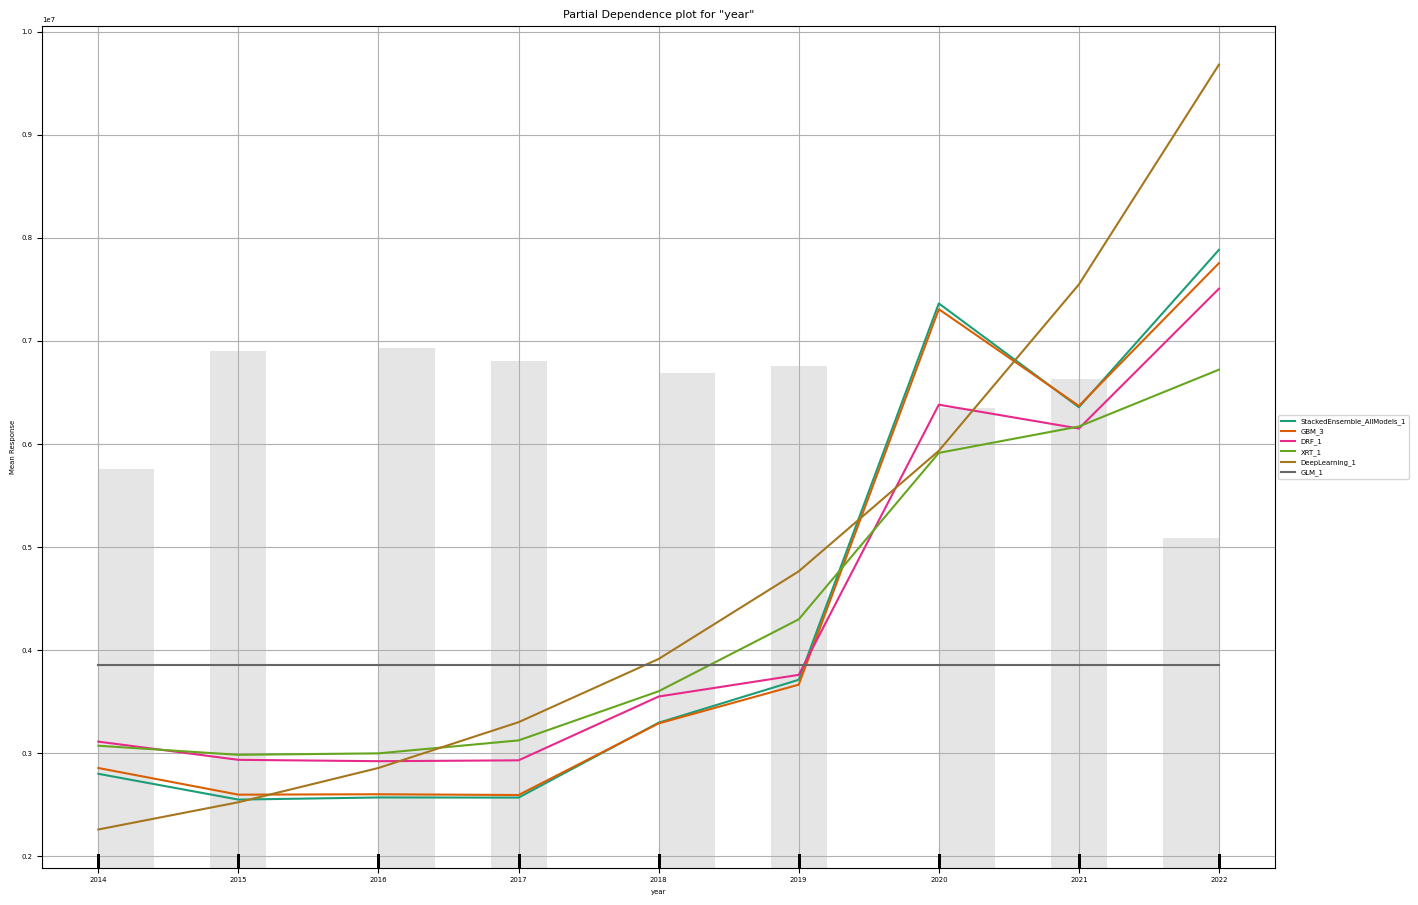

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

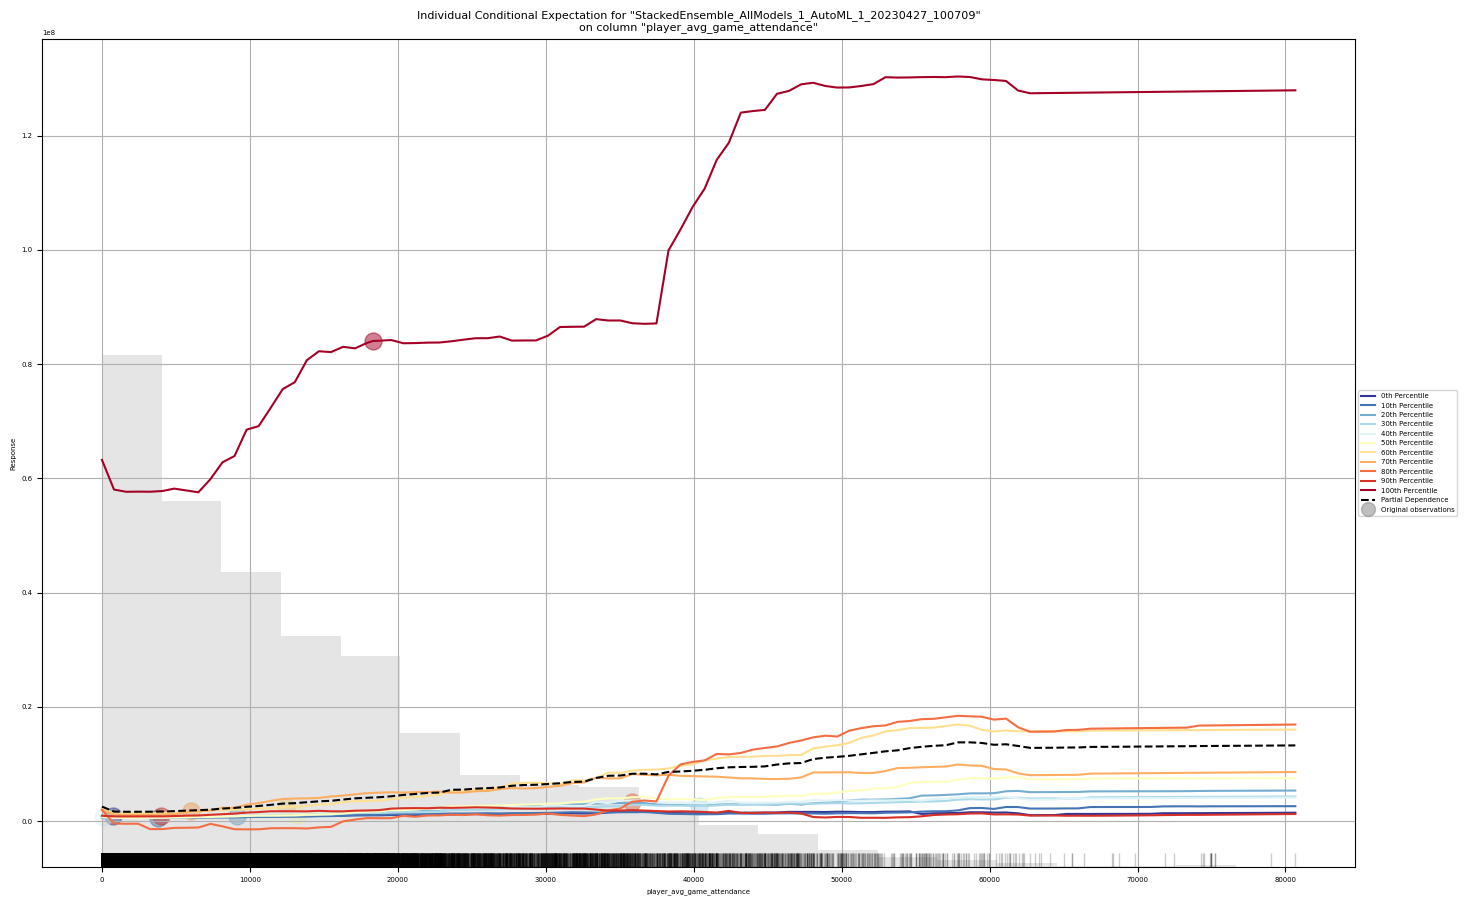

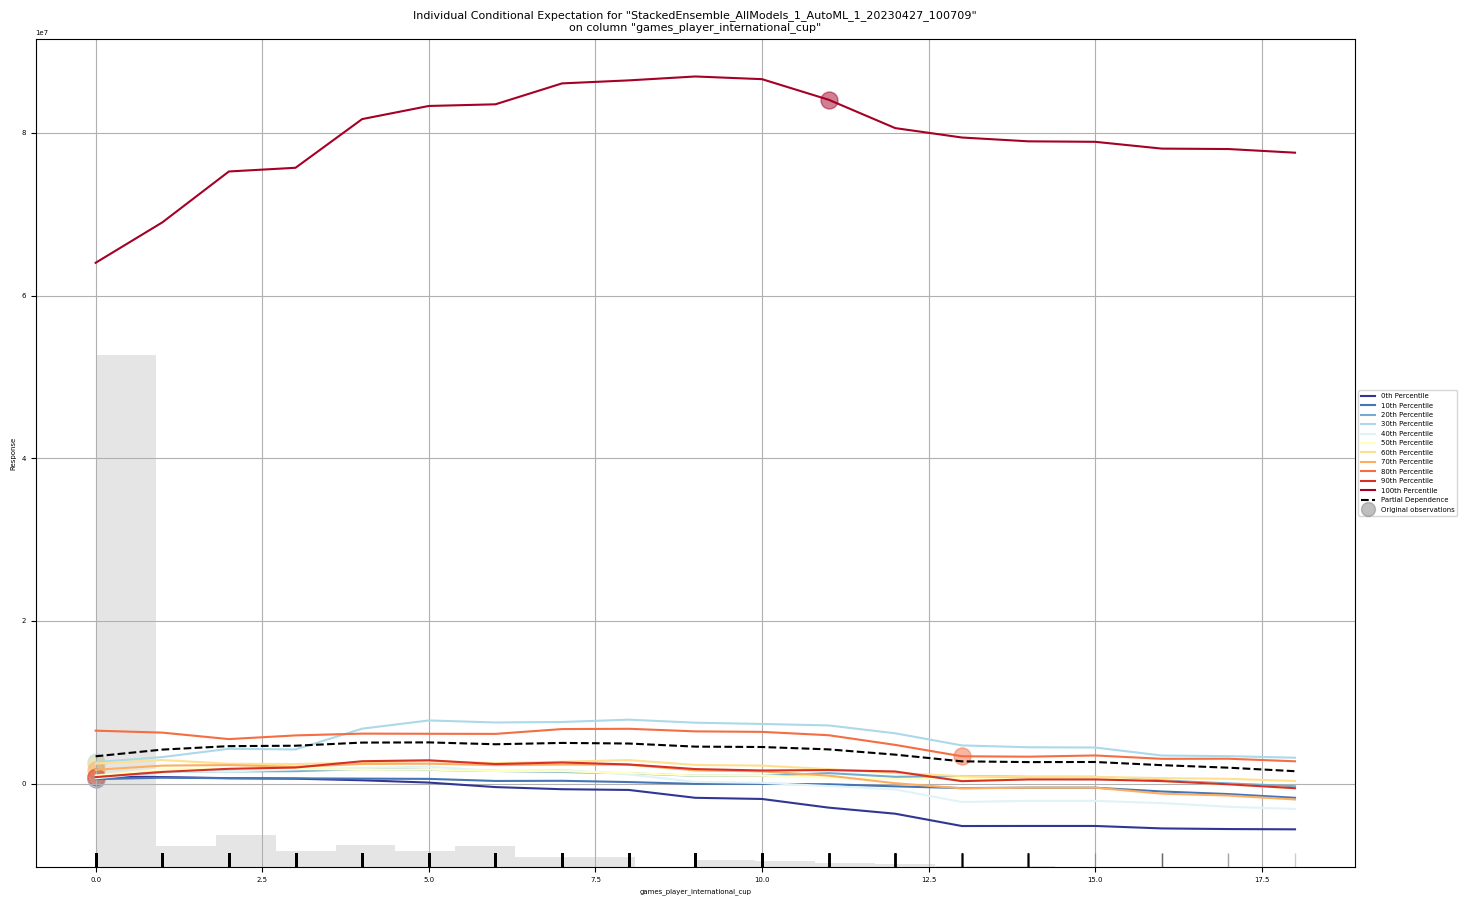

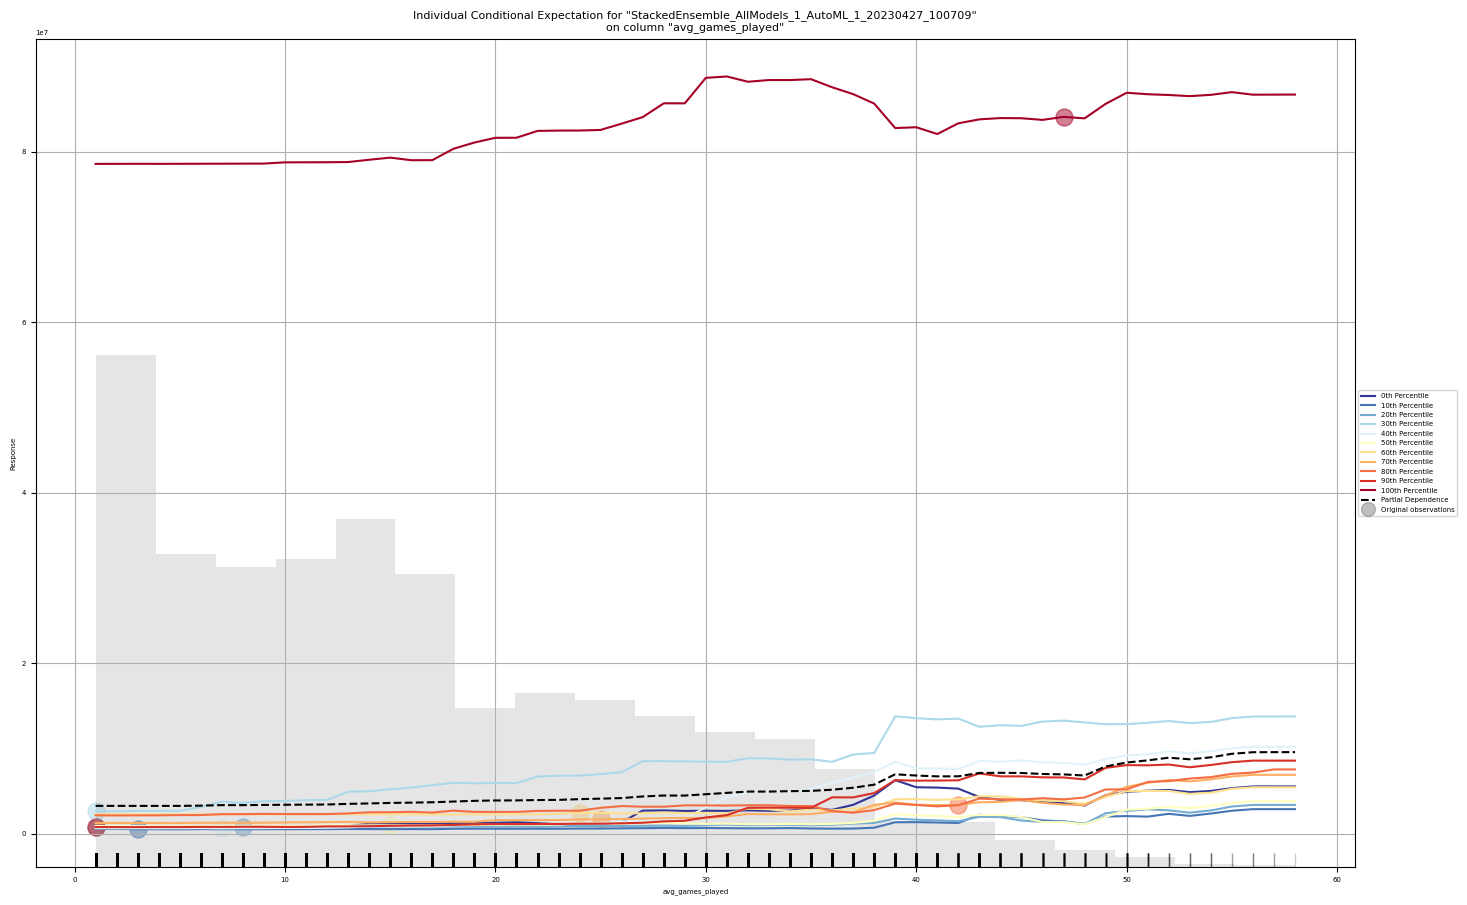

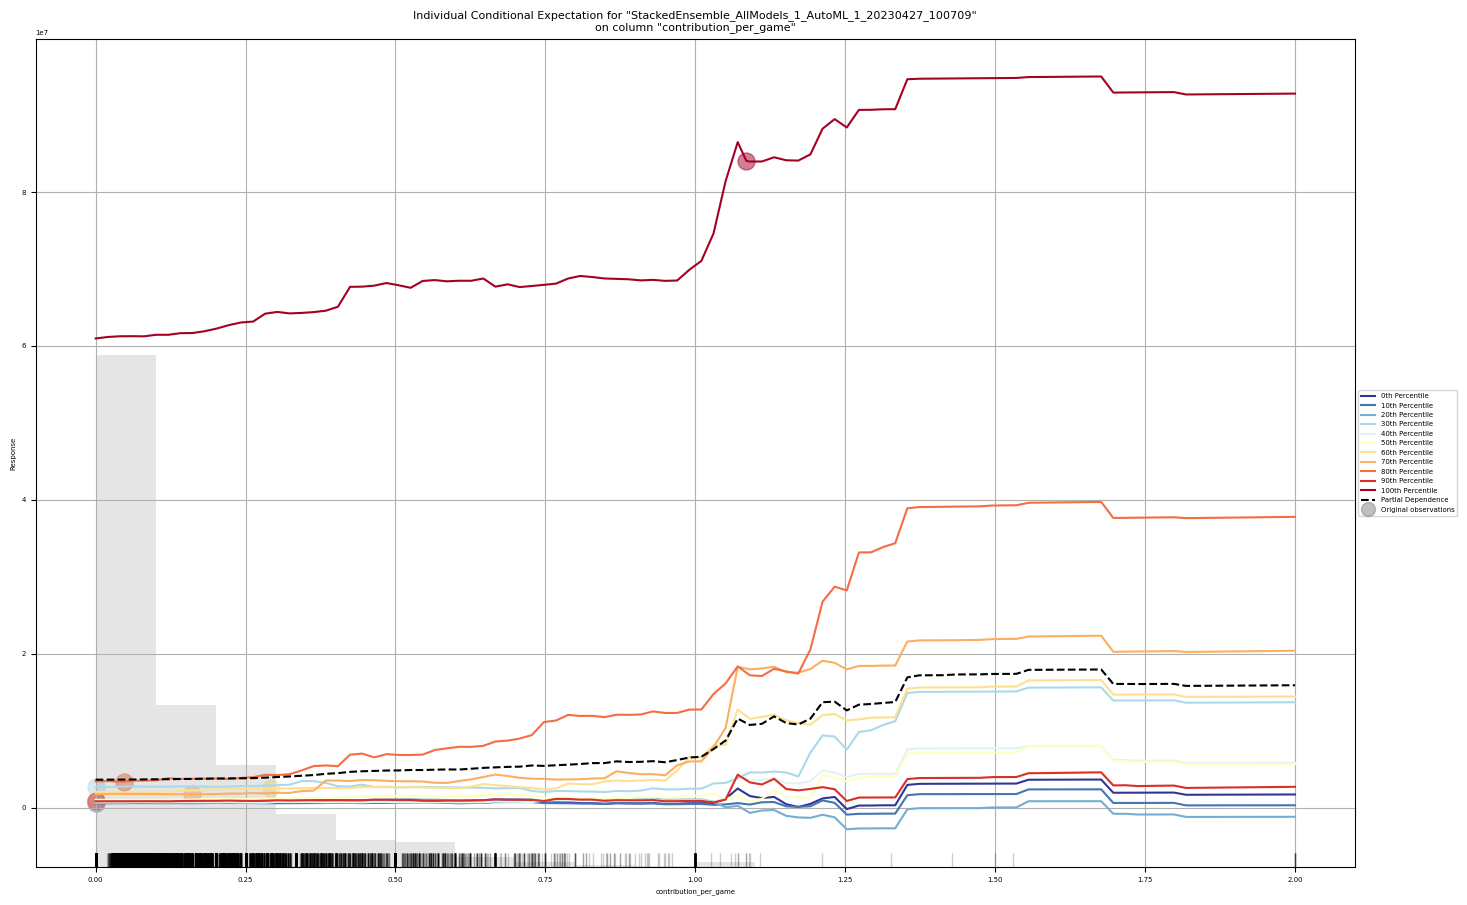

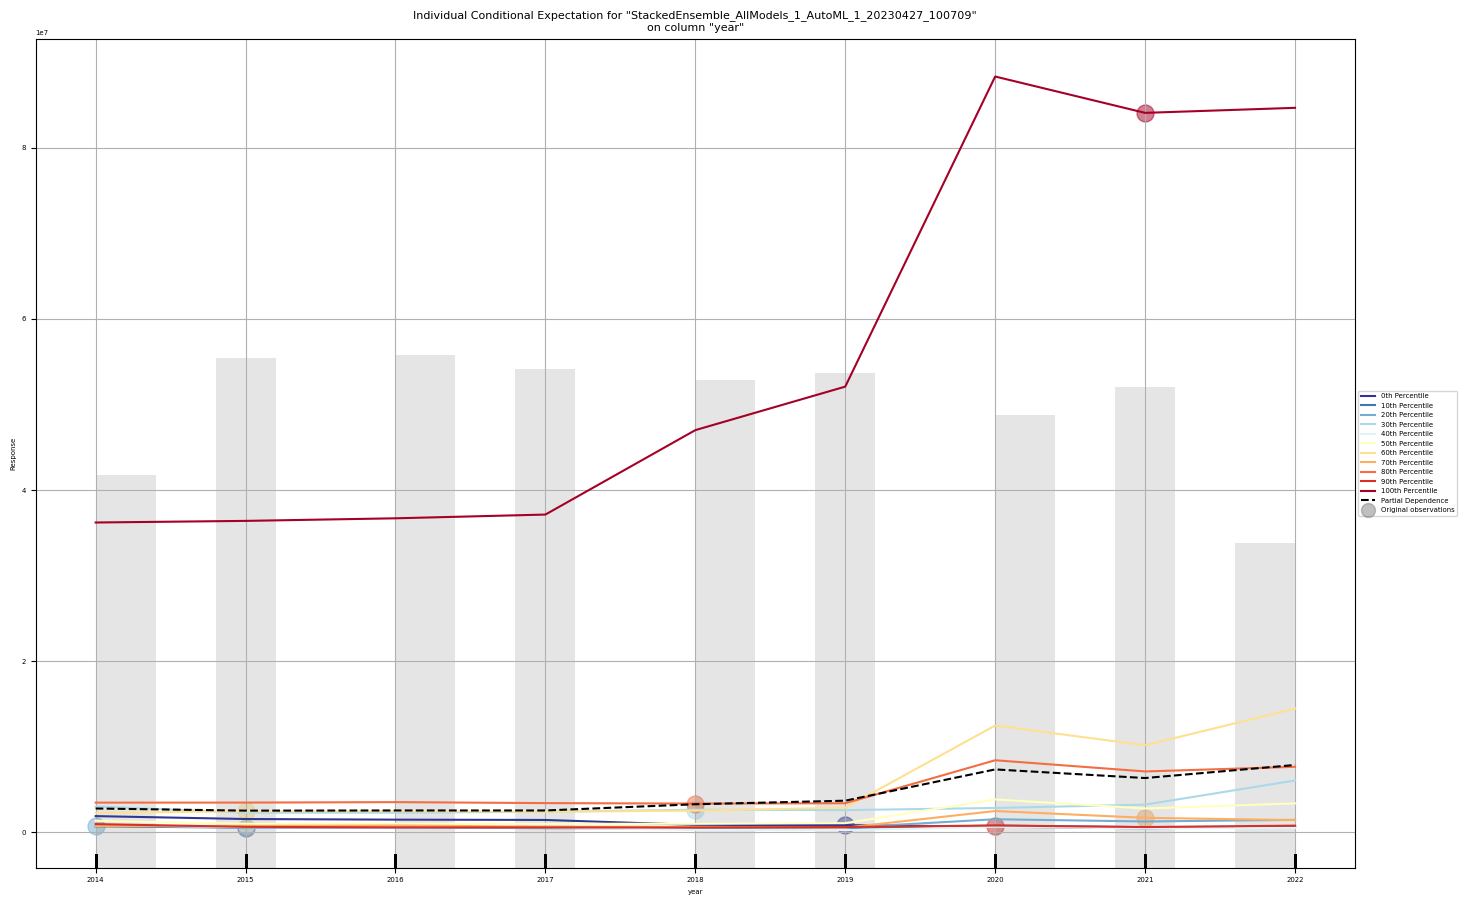

# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id,rmse,mse,mae,rmsle,mean_residual_deviance,training_time_ms,predict_time_per_row_ms,algo
StackedEnsemble_AllModels_1_AutoML_1_20230427_100709,4.87162e+06,2.37327e+13,2.17312e+06,nan,2.37327e+13,1388,0.021238,StackedEnsemble
GBM_3_AutoML_1_20230427_100709,4.94177e+06,2.44211e+13,2.22009e+06,nan,2.44211e+13,2216,0.002584,GBM
StackedEnsemble_BestOfFamily_1_AutoML_1_20230427_100709,4.94223e+06,2.44256e+13,2.20372e+06,nan,2.44256e+13,1713,0.0086,StackedEnsemble
GBM_4_AutoML_1_20230427_100709,4.94346e+06,2.44378e+13,2.2054e+06,nan,2.44378e+13,3379,0.002707,GBM
GBM_2_AutoML_1_20230427_100709,4.94907e+06,2.44933e+13,2.22503e+06,nan,2.44933e+13,1817,0.002796,GBM
GBM_5_AutoML_1_20230427_100709,5.03592e+06,2.53605e+13,2.25303e+06,nan,2.53605e+13,1789,0.002783,GBM
GBM_1_AutoML_1_20230427_100709,5.16549e+06,2.66823e+13,2.28948e+06,nan,2.66823e+13,4673,0.004721,GBM
GBM_grid_1_AutoML_1_20230427_100709_model_1,5.27272e+06,2.78016e+13,2.46364e+06,nan,2.78016e+13,4757,0.005241,GBM
DRF_1_AutoML_1_20230427_100709,5.3172e+06,2.82727e+13,2.36963e+06,1.10059,2.82727e+13,22155,0.004476,DRF
XRT_1_AutoML_1_20230427_100709,5.47719e+06,2.99996e+13,2.45782e+06,1.12734,2.99996e+13,24665,0.004475,DRF


# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

In [67]:
aml.explain(test)


## Model 



#### Random Forest

In [68]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

rf = RandomForestRegressor(n_estimators=100, random_state=0)
rf.fit(X_train_pca, y_train)

pred1 = rf.predict(X_valid_pca)
rf_mse = mean_squared_error(y_valid, pred1)
rf_rmse = np.sqrt(rf_mse)
rf_rmse

6796588.836829235

#### SVR

In [69]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(X_train_pca, y_train)
pred2 = svm_reg.predict(X_valid_pca)


In [70]:
svm_mse = mean_squared_error(y_valid, pred2)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

9413266.068636084

#### XGBoost

In [71]:
import xgboost as xgb
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror')
xg_reg.fit(X_train_pca, y_train)

pred3 = xg_reg.predict(X_valid_pca)
xgbt_rmse = np.sqrt(mean_squared_error(y_valid, pred3))
xgbt_rmse


6962732.060251345

#### Gradient Boosting Tree



In [72]:
from sklearn.ensemble import GradientBoostingRegressor


gbt = GradientBoostingRegressor(random_state=0)
model2 = gbt.fit(X_train_pca,y_train)
pred4 = model2.predict(X_valid_pca)
gbt_rmse = np.sqrt(mean_squared_error(y_valid, pred4))
gbt_rmse

6802030.1616788935

#### LGBM

In [73]:
from lightgbm import LGBMRegressor
# fit the model on the whole dataset
lgbm_reg_model = LGBMRegressor()
lgbm_reg_model.fit(X_train_pca, y_train)

#Testing
pred5 = lgbm_reg_model.predict(X_valid_pca)
lgbm_reg_mse = mean_squared_error(y_valid, pred5)
lgbm_reg_rmse = np.sqrt(lgbm_reg_mse)
lgbm_reg_rmse

6636563.34411674

In [74]:
X_valid_pca

#Index the array with the player ID
#Save it to the pickle file
# Pickle the actual model

array([[-4.15304123,  0.43452482,  0.26255391, ..., -0.99317234,
        -0.57385963, -0.49556061],
       [-3.24046294,  0.80316749, -0.49943873, ...,  0.33258862,
         0.23143895,  0.60895914],
       [ 0.68038559,  3.24741661,  4.22138233, ..., -1.38912673,
        -0.39175317, -0.11826945],
       ...,
       [ 1.90097487,  0.7124693 , -0.89139936, ...,  0.34803728,
         0.24949432,  1.55342069],
       [-2.08979806,  2.01387678, -1.73017882, ...,  0.04274475,
        -0.28478136,  0.31034021],
       [-2.12088114, -2.39267217,  0.88041963, ...,  0.61665457,
        -0.39697486,  0.5996147 ]])

Text(0, 0.5, 'Models')

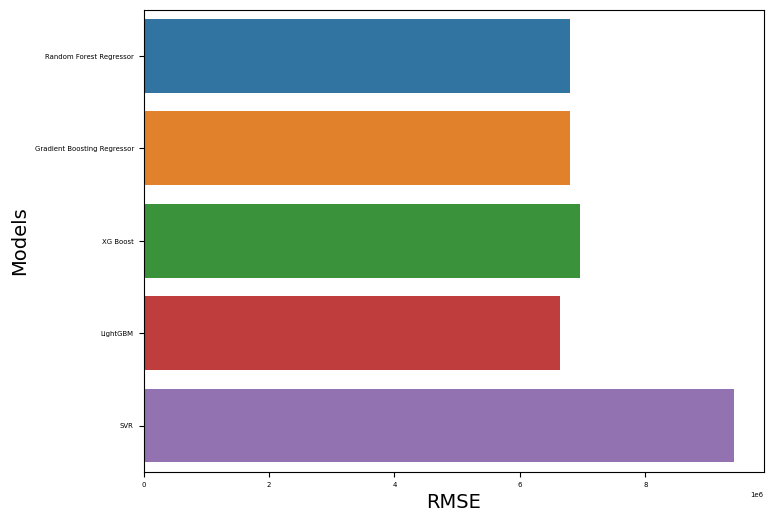

In [75]:
import seaborn as sns
df = {'Models': ["Random Forest Regressor","Gradient Boosting Regressor", 'XG Boost','LightGBM','SVR'],
     'RMSE': [rf_rmse,gbt_rmse,xgbt_rmse,lgbm_reg_rmse,svm_rmse]
     }

summary = pd.DataFrame(df)
plt.figure(figsize=(8, 6))
splot=sns.barplot(x="RMSE",y="Models",data=summary)
plt.xlabel("RMSE", size=14)
plt.ylabel("Models", size=14)

## Hyper Parameter Optimization -MLFlow

In [76]:
#!pip install mlflow


In [77]:
!pip install hyperopt

In [78]:
# ! pip install mlflow

In [79]:
import mlflow
import mlflow.lightgbm
from sklearn.model_selection import cross_val_score
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK, space_eval
from hyperopt.pyll import scope
import numpy as np
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

search_space = {
    "max_depth": scope.int(hp.quniform("max_depth", 2, 100, 5)),
    "n_estimators": scope.int(hp.quniform("n_estimators", 2, 100, 1)),
    "learning_rate": hp.loguniform("learning_rate", np.log(0.01), np.log(0.5)),
    "reg_alpha": hp.loguniform("reg_alpha", -5, 5),
    "min_child_weight": hp.uniform("min_child_weight", 0.5, 10),
}

def train_model(params):
    mlflow.lightgbm.autolog()
    with mlflow.start_run(nested=True):
        booster = LGBMRegressor()
        booster.set_params(**params)
        booster.fit(X_train, y_train)
        score = cross_val_score(
            booster,
            X_train,
            y_train,
            cv=5,
            scoring="neg_mean_squared_error",
            n_jobs=-1,
        )
        mean_score = np.mean(score)
        mlflow.log_params(params)
        mlflow.log_metric("neg_mean_squared_error", -1 * mean_score)
        return {"status": STATUS_OK, "loss": mean_score, "booster": booster.get_params()}

with mlflow.start_run(run_name="lgbmmodel"):
    best_params = fmin(
        fn=train_model,
        space=search_space,
        algo=tpe.suggest,
        max_evals=5,
        trials=Trials(),
        rstate=np.random.default_rng(123),
    )

2023/04/27 10:18:40 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh()

All git commands will error until this is rectified.

This initial warning can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|none|n|0: for no warning or exception
    - warn|w|warning|1: for a printed warning
    - error|e|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



  0%|          | 0/5 [00:00<?, ?trial/s, best loss=?]

2023/04/27 10:18:41 ERROR mlflow.lightgbm: Failed to log feature importance plot. LightGBM autologging will ignore the failure and continue. Exception: 
Traceback (most recent call last):
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\lightgbm.py", line 785, in train_impl
    log_feature_importance_plot(features, importance, imp_type)
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\lightgbm.py", line 700, in log_feature_importance_plot
    mlflow.log_artifact(filepath)
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\tracking\fluent.py", line 783, in log_artifact
    MlflowClient().log_artifact(run_id, local_path, artifact_path)
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\tracking\client.py", line 1028, in log_artifact
    self._tracking_client.log_artifact(run_id, local_path, artifact_path)
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\tracking\_tracking_service\cli

 20%|██        | 1/5 [00:16<01:07, 16.77s/trial, best loss: -71844352990529.81]

2023/04/27 10:18:58 ERROR mlflow.lightgbm: Failed to log feature importance plot. LightGBM autologging will ignore the failure and continue. Exception: 
Traceback (most recent call last):
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\lightgbm.py", line 785, in train_impl
    log_feature_importance_plot(features, importance, imp_type)
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\lightgbm.py", line 700, in log_feature_importance_plot
    mlflow.log_artifact(filepath)
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\tracking\fluent.py", line 783, in log_artifact
    MlflowClient().log_artifact(run_id, local_path, artifact_path)
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\tracking\client.py", line 1028, in log_artifact
    self._tracking_client.log_artifact(run_id, local_path, artifact_path)
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\tracking\_tracking_service\cli

 40%|████      | 2/5 [00:26<00:38, 12.68s/trial, best loss: -71844352990529.81]

2023/04/27 10:19:08 ERROR mlflow.lightgbm: Failed to log feature importance plot. LightGBM autologging will ignore the failure and continue. Exception: 
Traceback (most recent call last):
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\lightgbm.py", line 785, in train_impl
    log_feature_importance_plot(features, importance, imp_type)
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\lightgbm.py", line 700, in log_feature_importance_plot
    mlflow.log_artifact(filepath)
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\tracking\fluent.py", line 783, in log_artifact
    MlflowClient().log_artifact(run_id, local_path, artifact_path)
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\tracking\client.py", line 1028, in log_artifact
    self._tracking_client.log_artifact(run_id, local_path, artifact_path)
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\tracking\_tracking_service\cli

 60%|██████    | 3/5 [00:36<00:23, 11.53s/trial, best loss: -71844352990529.81]

2023/04/27 10:19:18 ERROR mlflow.lightgbm: Failed to log feature importance plot. LightGBM autologging will ignore the failure and continue. Exception: 
Traceback (most recent call last):
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\lightgbm.py", line 785, in train_impl
    log_feature_importance_plot(features, importance, imp_type)
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\lightgbm.py", line 700, in log_feature_importance_plot
    mlflow.log_artifact(filepath)
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\tracking\fluent.py", line 783, in log_artifact
    MlflowClient().log_artifact(run_id, local_path, artifact_path)
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\tracking\client.py", line 1028, in log_artifact
    self._tracking_client.log_artifact(run_id, local_path, artifact_path)
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\tracking\_tracking_service\cli

 80%|████████  | 4/5 [00:41<00:08,  8.95s/trial, best loss: -71928734844474.25]

2023/04/27 10:19:23 ERROR mlflow.lightgbm: Failed to log feature importance plot. LightGBM autologging will ignore the failure and continue. Exception: 
Traceback (most recent call last):
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\lightgbm.py", line 785, in train_impl
    log_feature_importance_plot(features, importance, imp_type)
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\lightgbm.py", line 700, in log_feature_importance_plot
    mlflow.log_artifact(filepath)
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\tracking\fluent.py", line 783, in log_artifact
    MlflowClient().log_artifact(run_id, local_path, artifact_path)
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\tracking\client.py", line 1028, in log_artifact
    self._tracking_client.log_artifact(run_id, local_path, artifact_path)
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\tracking\_tracking_service\cli

100%|██████████| 5/5 [00:47<00:00,  9.59s/trial, best loss: -71928734844474.25]


In [80]:
from hyperopt import space_eval
space_eval(search_space, best_params)

{'learning_rate': 0.01469081611405788,
 'max_depth': 80,
 'min_child_weight': 4.890633893892036,
 'n_estimators': 5,
 'reg_alpha': 2.2840138448783156}

In [81]:
# Define the LGBM model with the specified parameters
lgbm_model = lgb.LGBMRegressor(
    learning_rate=0.01469081611405788,
    max_depth=80,
    min_child_weight=4.890633893892036,
    n_estimators=5,
    reg_alpha=2.2840138448783156
)

# fit the model on the whole dataset
lgbm_model.fit(X_train_pca, y_train)

#Testing
pred = lgbm_model.predict(X_valid_pca)
lgbm_reg_mse = mean_squared_error(y_valid, pred)
lgbm_reg_rmse = np.sqrt(lgbm_reg_mse)
lgbm_reg_rmse

2023/04/27 10:19:28 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'b06f65cd5ee64d2ab906138ff78c7979', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current lightgbm workflow
2023/04/27 10:19:29 ERROR mlflow.lightgbm: Failed to log feature importance plot. LightGBM autologging will ignore the failure and continue. Exception: 
Traceback (most recent call last):
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\lightgbm.py", line 785, in train_impl
    log_feature_importance_plot(features, importance, imp_type)
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\lightgbm.py", line 700, in log_feature_importance_plot
    mlflow.log_artifact(filepath)
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\tracking\fluent.py", line 783, in log_artifact
    MlflowClient().log_artifact(run_id, local_path, artifact_path)
  File "C:\Users\nguye\anaconda3

8774604.33099992

In [82]:
import pickle
pickle.dump(lgbm_model, open('model.pkl','wb'))

## The data used for the model

In [83]:
X_train_pca_df= pd.DataFrame(X_train_pca)
X_train_pca_df

,0,1,2,3,4,5,6,7
0,0.811102,-1.776612,-0.674334,0.681444,1.053990,-1.849818,0.246342,-0.443042
1,0.479155,0.026488,1.274307,-0.603728,-1.047866,0.466599,0.121370,-0.495540
2,-0.579734,0.191582,2.381133,0.039084,0.440461,1.901303,0.252549,0.822577
3,-1.833107,-0.765295,-0.240980,0.150663,0.014059,0.519086,0.327810,0.879585
4,-2.926247,1.516087,-1.087604,-0.198557,-1.223349,0.288436,-0.679992,-0.043401
...,...,...,...,...,...,...,...,...
45442,-1.588060,1.640138,-1.493654,1.829801,2.383094,0.333480,7.761536,-3.106816
45443,-1.000738,-0.261373,-0.993623,2.172783,2.037156,-1.664934,0.383050,0.115527
45444,2.304197,-0.531802,-0.439560,0.353489,0.209275,0.060684,0.316936,-0.780238
45445,-3.132117,3.015185,-1.984423,-0.182893,-1.936823,0.172890,0.046697,-1.058795


In [84]:
X_train_id_df = X_train_id.to_frame()
X_train_id_df = X_train_id_df.reset_index(drop=True)
X_train_id_df



,player_id
0,89618
1,61653
2,212415
3,351837
4,354909
...,...
45442,60543
45443,178540
45444,68390
45445,55510


In [85]:
merged_table = pd.merge(X_train_id_df, X_train_pca_df, left_index=True, right_index=True)
merged_table

,player_id,0,1,2,3,4,5,6,7
0,89618,0.811102,-1.776612,-0.674334,0.681444,1.053990,-1.849818,0.246342,-0.443042
1,61653,0.479155,0.026488,1.274307,-0.603728,-1.047866,0.466599,0.121370,-0.495540
2,212415,-0.579734,0.191582,2.381133,0.039084,0.440461,1.901303,0.252549,0.822577
3,351837,-1.833107,-0.765295,-0.240980,0.150663,0.014059,0.519086,0.327810,0.879585
4,354909,-2.926247,1.516087,-1.087604,-0.198557,-1.223349,0.288436,-0.679992,-0.043401
...,...,...,...,...,...,...,...,...,...
45442,60543,-1.588060,1.640138,-1.493654,1.829801,2.383094,0.333480,7.761536,-3.106816
45443,178540,-1.000738,-0.261373,-0.993623,2.172783,2.037156,-1.664934,0.383050,0.115527
45444,68390,2.304197,-0.531802,-0.439560,0.353489,0.209275,0.060684,0.316936,-0.780238
45445,55510,-3.132117,3.015185,-1.984423,-0.182893,-1.936823,0.172890,0.046697,-1.058795


In [86]:
merged_table.to_csv('X_train_pca.csv', index=False)